# Extract biometrics from segmentation results

## Volumetry

Literature

In [67]:
from cmath import pi

# Measures
# GLOBE
# The means for the horizontal and vertical diameters are 24.26 ± 0.96 mm (n = 518) and 24.16 ± 0.97 mm (n = 510), respectively.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3432692/#:~:text=In%20the%20adult%2C%20the%20spherical,11.8%20and%2011.2%20mm%2C%20respectively
globe_avg_diameter = 24.2 # mm
globe_avg_volume = 4/3*pi*((globe_avg_diameter/2)**3) # mm³
print(globe_avg_volume)

7420.697363981582


Compute volumes

In [44]:
import os
import numpy as np
import nibabel as nb

METHOD = 'reg'

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = np.zeros(len_path)
vol_lens = np.zeros(len_path)
vol_globe = np.zeros(len_path)
vol_nerve = np.zeros(len_path)
vol_int_fat = np.zeros(len_path)
vol_ext_fat = np.zeros(len_path)
vol_lat_mus = np.zeros(len_path)
vol_med_mus = np.zeros(len_path)
vol_inf_mus = np.zeros(len_path)
vol_sup_mus = np.zeros(len_path)

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg': lab_arr = nb.load(f'{input_path}{folder1}/labels.nii.gz').get_fdata()
    elif METHOD=='dl': lab_arr = nb.load(f'{input_path}{folder1}').get_fdata()

    # Subject's name
    if METHOD=='reg': name_subject[i] = folder1
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    print(f'subject: {name_subject[i]}')

    # Total volumetry of the subject's eye
    total_vol = np.count_nonzero(lab_arr)
    print(f'Total volume of the eye: {total_vol} mm³')

    # Lens
    vol_lens[i] = np.count_nonzero(lab_arr==1) / total_vol
    print(f'lens {vol_lens[i]}')

    # Globe
    vol_globe[i] = np.count_nonzero(lab_arr==2) / total_vol
    print(f'globe {vol_globe[i]}')

    # Nerve
    vol_nerve[i] = np.count_nonzero(lab_arr==3) / total_vol
    print(f'nerve {vol_nerve[i]}')

    # Intraconal fat
    vol_int_fat[i] = np.count_nonzero(lab_arr==4) / total_vol
    print(f'intraconal fat {vol_int_fat[i]}')

    # Extraconal fat
    vol_ext_fat[i] = np.count_nonzero(lab_arr==5) / total_vol
    print(f'extraconal fat {vol_ext_fat[i]}')

    # Lateral rectus muscle
    vol_lat_mus[i] = np.count_nonzero(lab_arr==6) / total_vol
    print(f'lateral rectus muscle {vol_lat_mus[i]}')

    # Medial rectus muscle
    vol_med_mus[i] = np.count_nonzero(lab_arr==7) / total_vol
    print(f'medial rectus muscle {vol_med_mus[i]}')

    # Inferior rectus muscle
    vol_inf_mus[i] = np.count_nonzero(lab_arr==8) / total_vol
    print(f'medial rectus muscle {vol_inf_mus[i]}')

    # Superior rectus muscle
    vol_sup_mus[i] = int(np.count_nonzero(lab_arr==9)) / total_vol
    print(f'superior rectus muscle {vol_sup_mus[i]}')

    i+=1
    # if i==1:
    #     break

subject: 2022160100001.0
Total volume of the eye: 18710 mm³
lens 0.0051309460181721
globe 0.3157135221806521
nerve 0.03671833244254409
intraconal fat 0.19727418492784607
extraconal fat 0.27215392838054514
lateral rectus muscle 0.0322287546766435
medial rectus muscle 0.04179583110636024
medial rectus muscle 0.037252805986103685
superior rectus muscle 0.061731694281133086
subject: 2022160100002.0
Total volume of the eye: 17914 mm³
lens 0.004186669643853969
globe 0.3431394440102713
nerve 0.031037177626437422
intraconal fat 0.21050574969297756
extraconal fat 0.22714078374455732
lateral rectus muscle 0.027576197387518143
medial rectus muscle 0.04181087417662164
medial rectus muscle 0.0430389639388188
superior rectus muscle 0.07156413977894384
subject: 2022160100003.0
Total volume of the eye: 20820 mm³
lens 0.0028338136407300672
globe 0.30499519692603266
nerve 0.03515850144092219
intraconal fat 0.21935638808837657
extraconal fat 0.25024015369836694
lateral rectus muscle 0.03208453410182517
m

Save values into .csv

In [45]:
import csv

if METHOD=='reg': filename = 'volumes_reg_norm.csv'
elif METHOD=='dl': filename = 'volumes_dl.csv'

column_names = ['Subject','vol_lens','vol_globe','vol_nerve','vol_int_fat','vol_ext_fat','vol_lat_mus','vol_med_mus','vol_inf_mus','vol_sup_mus']
vals = np.array([name_subject, vol_lens, vol_globe, vol_nerve, vol_int_fat, vol_ext_fat, vol_lat_mus, vol_med_mus, vol_inf_mus, vol_sup_mus])
vals = vals.T
with open(main_path + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

Read values from .csv

lens - mean: 0.004073878016855692, std: 0.0007511235051780083
globe - mean: 0.3037817733877374, std: 0.035084166063781376
nerve - mean: 0.03517790253526914, std: 0.0032779310006400384
intraconal fat - mean: 0.22031039839223487, std: 0.017868764730663397
extraconal fat - mean: 0.2508449272845684, std: 0.021940988501516833
lateral rectus muscle - mean: 0.03289264450873385, std: 0.00321390695367581
medial rectus muscle - mean: 0.04547915169648177, std: 0.004621740697622422
inferior rectus muscle - mean: 0.04085971310564071, std: 0.00390597139581722
superior rectus muscle - mean: 0.06657961107247787, std: 0.006899476643958443


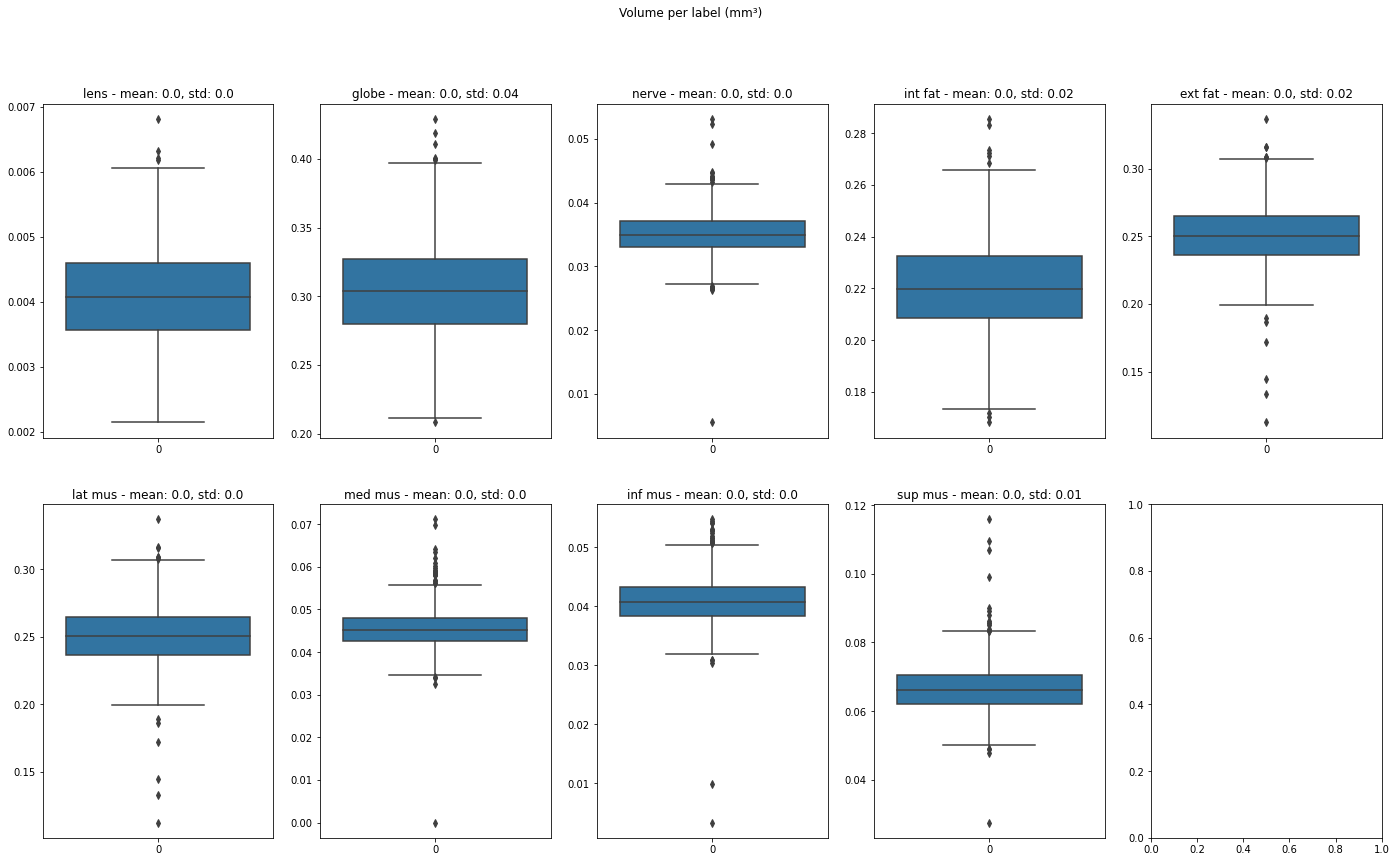

In [46]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

METHOD = 'reg'

if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    filename = 'volumes_reg_norm.csv'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    filename = 'volumes_dl.csv'

df_vol = pd.read_csv(main_path + filename)

# lens
vol_lens = np.array([df_vol["vol_lens"]])
print(f'lens - mean: {np.mean(vol_lens)}, std: {np.std(vol_lens)}')

# globe
vol_globe = np.array([df_vol["vol_globe"]])
print(f'globe - mean: {np.mean(vol_globe)}, std: {np.std(vol_globe)}')

# nerve
vol_nerve = np.array([df_vol["vol_nerve"]])
print(f'nerve - mean: {np.mean(vol_nerve)}, std: {np.std(vol_nerve)}')

# intraconal fat
vol_int_fat = np.array([df_vol["vol_int_fat"]])
print(f'intraconal fat - mean: {np.mean(vol_int_fat)}, std: {np.std(vol_int_fat)}')

# extraconal fat
vol_ext_fat = np.array([df_vol["vol_ext_fat"]])
print(f'extraconal fat - mean: {np.mean(vol_ext_fat)}, std: {np.std(vol_ext_fat)}')

# lateral rectus muscle
vol_lat_mus = np.array([df_vol["vol_lat_mus"]])
print(f'lateral rectus muscle - mean: {np.mean(vol_lat_mus)}, std: {np.std(vol_lat_mus)}')

# medial rectus muscle
vol_med_mus= np.array([df_vol["vol_med_mus"]])
print(f'medial rectus muscle - mean: {np.mean(vol_med_mus)}, std: {np.std(vol_med_mus)}')

# inferior rectus muscle
vol_inf_mus = np.array([df_vol["vol_inf_mus"]])
print(f'inferior rectus muscle - mean: {np.mean(vol_inf_mus)}, std: {np.std(vol_inf_mus)}')

# superior rectus muscle
vol_sup_mus = np.array([df_vol["vol_sup_mus"]])
print(f'superior rectus muscle - mean: {np.mean(vol_sup_mus)}, std: {np.std(vol_sup_mus)}')

# Subplots
k = 1.5 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig.suptitle('Volume per label (mm³)')
fig.patch.set_facecolor('white')
fix_axis = False
# x_axis = [-2, 2]
# y_axis = [-2.5, 3.5]

# lens
ax[0][0].set_title(f'lens - mean: {np.round(np.mean(vol_lens))}, std: {np.round(np.std(vol_lens), 2)}')
graph_lens = sns.boxplot(df_vol['vol_lens'], ax=ax[0][0])
# graph_lens.axhline(np.round(np.mean(vol_lens)), color='red')
if fix_axis:
    # ax[0][0].set_xlim(x_axis)
    ax[0][0].set_ylim([0, 160])

# globe
ax[0][1].set_title(f'globe - mean: {np.round(np.mean(vol_globe))}, std: {np.round(np.std(vol_globe), 2)}')
graph_globe = sns.boxplot(df_vol['vol_globe'], ax=ax[0][1])
# graph_globe.axhline(np.round(np.mean(vol_globe)), color='red')
if fix_axis:
    # ax[0][1].set_xlim(x_axis)
    ax[0][1].set_ylim([2500, 9000])

# nerve
ax[0][2].set_title(f'nerve - mean: {np.round(np.mean(vol_nerve))}, std: {np.round(np.std(vol_nerve), 2)}')
graph_nerve = sns.boxplot(df_vol['vol_nerve'], ax=ax[0][2])
# graph_nerve.axhline(np.round(np.mean(vol_nerve)), color='red')
if fix_axis:
    # ax[0][2].set_xlim(x_axis)
    ax[0][2].set_ylim([300, 1100])

# intraconal fat
ax[0][3].set_title(f'int fat - mean: {np.round(np.mean(vol_int_fat))}, std: {np.round(np.std(vol_int_fat), 2)}')
graph_int_fat = sns.boxplot(df_vol['vol_int_fat'], ax=ax[0][3])
# graph_int_fat.axhline(np.round(np.mean(vol_int_fat)), color='red')
if fix_axis:
    # ax[0][3].set_xlim(x_axis)
    ax[0][3].set_ylim([2000, 7000])

# extraconal fat
ax[0][4].set_title(f'ext fat - mean: {np.round(np.mean(vol_ext_fat))}, std: {np.round(np.std(vol_ext_fat), 2)}')
graph_ext_fat = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[0][4])
# graph_ext_fat.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[0][4].set_xlim(x_axis)
    ax[0][4].set_ylim([1000, 7000])

# lateral rectus muscle
ax[1][0].set_title(f'lat mus - mean: {np.round(np.mean(vol_lat_mus))}, std: {np.round(np.std(vol_lat_mus), 2)}')
graph_lat_mus = sns.boxplot(df_vol['vol_ext_fat'], ax=ax[1][0])
# graph_lat_mus.axhline(np.round(np.mean(vol_ext_fat)), color='red')
if fix_axis:
    # ax[1][0].set_xlim(x_axis)
    ax[1][0].set_ylim([1000, 8000])    

# medial rectus muscle
ax[1][1].set_title(f'med mus - mean: {np.round(np.mean(vol_med_mus))}, std: {np.round(np.std(vol_med_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_med_mus'], ax=ax[1][1])
# graph_med_mus.axhline(np.round(np.mean(vol_med_mus)), color='red')
if fix_axis:
    # ax[1][1].set_xlim(x_axis)
    ax[1][1].set_ylim([400, 1500])

# inferior rectus muscle
ax[1][2].set_title(f'inf mus - mean: {np.round(np.mean(vol_inf_mus))}, std: {np.round(np.std(vol_inf_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_inf_mus'], ax=ax[1][2])
# graph_med_mus.axhline(np.round(np.mean(vol_inf_mus)), color='red')
if fix_axis:
    # ax[1][2].set_xlim(x_axis)
    ax[1][2].set_ylim([400, 1300])

# superior rectus muscle
ax[1][3].set_title(f'sup mus - mean: {np.round(np.mean(vol_sup_mus))}, std: {np.round(np.std(vol_sup_mus), 2)}')
graph_med_mus = sns.boxplot(df_vol['vol_sup_mus'], ax=ax[1][3])
# graph_med_mus.axhline(np.round(np.mean(vol_sup_mus)), color='red')
if fix_axis:
    # ax[1][3].set_xlim(x_axis)
    ax[1][3].set_ylim([300, 2000])     

plt.show

plt.savefig(main_path + filename.split('.')[0] + '_boxplot_norm.png')

## Axial and equatorial lengths

### line 3D

com_lens: (33.0, 52.302083333333336, 37.572916666666664), 
com_globe: (32.6177416624344, 43.065007618080244, 36.97409852717115)
Number of points of the line in the image space: 74
Number of instersection points in lens: 5
Lens extreme intersection point: [33 54 38]
Number of instersection points in globe: 20
Globe extreme intersection point: [32 33 36]
Axial length = 21.119 mm


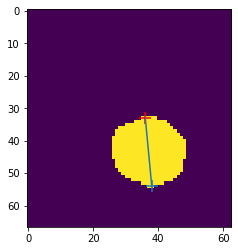

In [141]:
import os
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import math

METHOD = 'reg'

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = np.zeros(len_path)
axial_length_total = np.zeros(len_path)

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg': lab_arr = nb.load(f'{input_path}{folder1}/labels.nii.gz').get_fdata()
    elif METHOD=='dl': lab_arr = nb.load(f'{input_path}{folder1}').get_fdata()

    # Subject's name
    if METHOD=='reg': name_subject[i] = folder1
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    # print(name_subject[i])

    # Label masks
    eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
    globe = (lab_arr==2)*1
    lens = (lab_arr==1)*1

    # Center of mass - CENTROIDS
    # Lens
    properties_lens = regionprops(lens)
    com_lens = properties_lens[0].centroid
    # Globe
    properties_globe = regionprops(globe)
    com_globe = properties_globe[0].centroid
    print(f'com_lens: {com_lens}, \ncom_globe: {com_globe}')

    # # Center of mass - BOUNDING BOXES / 2
    # # Lens
    # properties_lens = regionprops(lens)
    # bbox_lens = properties_lens[0].bbox
    # com_lens = np.around([(bbox_lens[0]+bbox_lens[3])/2, (bbox_lens[1]+bbox_lens[4])/2, (bbox_lens[2]+bbox_lens[5])/2])
    # # Globe
    # properties_globe = regionprops(globe)
    # bbox_globe = properties_globe[0].bbox
    # com_globe = np.around([(bbox_globe[0]+bbox_globe[3])/2, (bbox_globe[1]+bbox_globe[4])/2, (bbox_globe[2]+bbox_globe[5])/2])
    # print(f'com_lens: {com_lens}, \ncom_globe: {com_globe}')

    # Parametric equation
    n_points = np.ceil(math.dist([0,0,0],[lab_arr.shape[0], lab_arr.shape[1], lab_arr.shape[2]])) # max number of points of a line in the image cube
    max_dist = int(np.abs(np.amax(np.abs([com_lens[0]-com_globe[0], com_lens[1]-com_globe[1], com_lens[2]-com_globe[2]]))))
    index_max_dist = np.argmax(np.abs([com_lens[0]-com_globe[0], com_lens[1]-com_globe[1], com_lens[2]-com_globe[2]])) # coordinate in which there is higher distance between labels' centroids
    # res = int(np.ceil((lab_arr.shape[index_max_dist]*2 - com_lens[index_max_dist]) / int(max_dist))) # resolution of the line (for the axis with higher distance)
    res = int(max_dist) + com_lens[index_max_dist] + 1 # resolution for the line (number of points)
    t = np.linspace(-int(n_points), int(n_points), int(int(n_points)*2*res+1)) # res determines line resolution, to have steps of 1 in the axis with higher distance
    line_x = (com_lens[0] - com_globe[0])*t + com_lens[0]
    line_y = (com_lens[1] - com_globe[1])*t + com_lens[1]
    line_z = (com_lens[2] - com_globe[2])*t + com_lens[2]

    # Line in image space (cube)
    line = np.zeros([lab_arr.shape[0], lab_arr.shape[1], lab_arr.shape[2]])
    for j in range(len(t)):
        if 0<=round(line_x[j])<lab_arr.shape[0] and 0<=round(line_y[j])<lab_arr.shape[1] and 0<=round(line_z[j])<lab_arr.shape[2]:
            line[round(line_x[j]), round(line_y[j]), round(line_z[j])] = 1
    print(f'Number of points of the line in the image space: {np.count_nonzero(line)}')

    # Intersections
    # Lens
    inter_lens = np.logical_and(lens, line)*1 # int format, intersection points in lens with line
    print(f'Number of instersection points in lens: {np.count_nonzero(inter_lens)}')
    inter_coord_lens = np.argwhere(inter_lens==1)
    extreme_inter_lens = inter_coord_lens[np.argmax(inter_coord_lens[:,index_max_dist])]
    print(f'Lens extreme intersection point: {extreme_inter_lens}')
    # Globe
    inter_globe = np.logical_and(globe, line)*1 # int format, intersection points in globe with line
    print(f'Number of instersection points in globe: {np.count_nonzero(inter_globe)}')
    inter_coord_globe = np.argwhere(inter_globe==1)
    extreme_inter_globe = inter_coord_globe[np.argmin(inter_coord_globe[:,index_max_dist])]
    print(f'Globe extreme intersection point: {extreme_inter_globe}')

    # Distance between two points in 3D
    axial_length = np.around(math.dist(extreme_inter_lens, extreme_inter_globe), decimals=3)
    print(f'Axial length = {axial_length} mm')

    axial_length_total[i] = axial_length

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(eyeball[int(np.around(com_lens[0])),:,:]) # round(len(lab_arr[2])/2)
    # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
    ax.scatter(extreme_inter_lens[2], extreme_inter_lens[1], s=160, c='C0', marker='+')
    ax.scatter(extreme_inter_globe[2], extreme_inter_globe[1], s=160, c='r', marker='+')
    x_axis = np.array([extreme_inter_lens[2], extreme_inter_globe[2]])
    y_axis = np.array([extreme_inter_lens[1], extreme_inter_globe[1]])
    plt.plot(x_axis, y_axis)
    plt.show()

    i+=1
    if i==1:
        break

### regionprops

subject: 2022160100001
com_lens: [33. 52. 38.]
axis minor lens = 3.49790675068067 
axis major lens = 7.358595468540871
orientation lens = 1.4836992710972654
com_globe: [33. 43. 37.]
axis minor globe = 20.286188171061177 
axis major globe = 23.96469175678346
axial length = 23.78 mm
Number of points of the line in the image space: 70
Number of instersection points in lens: 4
Lens extreme intersection point: [54 38]
Number of instersection points in globe: 19
Globe extreme intersection point: [33 36]
Axial length = 21.1 mm


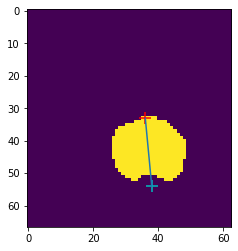

In [49]:
import os
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import math

METHOD = 'reg' # reg, dl, manual
LABEL = 'lens+globe' # eyeball, lens+globe

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'
elif METHOD=='manual':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/'
    input_path = main_path + 'a123/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
axial_length_total = np.zeros(len_path)
outliers = list()

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg': lab_arr = nb.load(f'{input_path}{folder1}/labels.nii.gz').get_fdata()
    elif METHOD=='dl': lab_arr = nb.load(f'{input_path}{folder1}').get_fdata()
    elif METHOD=='manual': lab_arr = nb.load(f'{input_path}{folder1}/input/{folder1}_labels_cropped.nii.gz').get_fdata()

    # Subject's name
    if METHOD=='reg' or METHOD=='manual': name_subject[i] = str(folder1)
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    print(f'subject: {name_subject[i]}')

    # Label masks
    lens = (lab_arr==1)*1
    globe = (lab_arr==2)*1
    eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
    if np.count_nonzero(lens)==0: outliers.append(name_subject[i])

    # PROPERTIES
    if LABEL == 'lens+globe':

        # LENS
        if np.count_nonzero(lens)!=0:
            properties_lens = regionprops(lens) # properties
            com_lens = properties_lens[0].centroid # centroid
            print(f'com_lens: {np.around(com_lens)}')
            axis_minor_lens = properties_lens[0].axis_minor_length # minor axis
            axis_major_lens = properties_lens[0].axis_major_length # major axis
            print(f'axis minor lens = {axis_minor_lens} \naxis major lens = {axis_major_lens}')
            orientation_lens = regionprops(lens[int(np.around(com_lens[0])), :, :])[0].orientation # orientation in 2D slice
            print(f'orientation lens = {orientation_lens}')
        else: axis_minor_lens = 0

        # GLOBE
        properties_globe = regionprops(globe) # properties
        com_globe = properties_globe[0].centroid # centroid
        print(f'com_globe: {np.around(com_globe)}')
        axis_minor_globe = properties_globe[0].axis_minor_length # minor axis
        axis_major_globe = properties_globe[0].axis_major_length # major axis
        print(f'axis minor globe = {axis_minor_globe} \naxis major globe = {axis_major_globe}')
        # orientation_globe = regionprops(globe[int(np.around(com_globe[0])), :, :])[0].orientation # orientation

        # AXIAL LENGTH
        axial_length = axis_minor_lens + axis_minor_globe
        print(f'axial length = {np.around(axial_length, decimals=2)} mm')

    elif LABEL == 'eyeball':
        
        # EYEBALL
        properties_eyeball = regionprops(eyeball) # properties
        com_eyeball = properties_eyeball[0].centroid # centroid
        print(f'com_eyeball: {np.around(com_eyeball)}')
        axis_minor_eyeball = properties_eyeball[0].axis_minor_length # minor axis
        axis_major_eyeball = properties_eyeball[0].axis_major_length # major axis
        print(f'axis minor eyeball = {axis_minor_eyeball} \naxis major eyeball = {axis_major_eyeball}')
        # orientation_eyeball = regionprops(eyeball[int(np.around(com_eyeball[0])), :, :])[0].orientation # orientation

        # AXIAL LENGTH
        if np.count_nonzero(lens)!=0:
            axial_length = axis_major_eyeball
        else: axial_length = 0
        print(f'axial length eyeball = {np.around(axial_length, decimals=2)} mm')

    axial_length_total[i] = axial_length

    # if axial_length <= 21 or axial_length >= 27.5: outliers.append(name_subject[i])

    # # Plot
    x0_lens = com_lens[0]
    y0_lens = com_lens[1]
    z0_lens = com_lens[2]
    # fig, ax = plt.subplots(figsize=(5, 5))
    # ax.imshow(lens[int(np.around(com_lens[0])),:,:]) # round(len(lab_arr[2])/2)
    # # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
    # # ax.scatter(com_lens[2], com_lens[1], s=150, c='C0', marker='+')
    # # ax.scatter(com_globe[2], com_globe[1], s=160, c='r', marker='+')
    # ax.plot(z0_lens, y0_lens, '+c', markersize=15)
    y1_lens = com_lens[1] + math.sin(orientation_lens) * 0.5 * axis_minor_lens
    z1_lens = com_lens[2] + math.cos(orientation_lens) * 0.5 * axis_minor_lens
    # ax.plot((z0_lens, z1_lens), (y0_lens, y1_lens), '-r', linewidth=1.5)
    # # plt.show()

    i+=1
    # if i==1:
    #     break

### Porespy
Amplified version of `skimage`

In [34]:
import os
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import math
from porespy.metrics import regionprops_3D

METHOD = 'reg'

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = np.zeros(len_path)
axial_length_total = np.zeros(len_path)

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg': lab_arr = nb.load(f'{input_path}{folder1}/labels.nii.gz').get_fdata()
    elif METHOD=='dl': lab_arr = nb.load(f'{input_path}{folder1}').get_fdata()

    # Subject's name
    if METHOD=='reg': name_subject[i] = folder1
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    # print(name_subject[i])

    # Label masks
    eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
    globe = (lab_arr==2)*1
    lens = (lab_arr==1)*1

    # Center of mass - CENTROIDS
    # Lens
    properties_lens = regionprops_3D(lens)
    # attrs = [a for a in properties_lens[0]] # it also has sphericity
    # print(attrs)
    com_lens = properties_lens[0].centroid
    # Globe
    properties_globe = regionprops_3D(globe)
    com_globe = properties_globe[0].centroid
    # Eyeball
    properties_eyeball = regionprops_3D(eyeball)
    com_eyeball = properties_eyeball[0].centroid
    print(f'com_lens: {com_lens}, \ncom_globe: {com_globe} \ncom_eyeball: {com_eyeball}')

    # Axis minor and major distances
    # Lens
    axis_minor_lens = properties_lens[0].axis_minor_length
    axis_major_lens = properties_lens[0].axis_major_length
    orientation_lens = regionprops(lens[int(np.around(com_lens[0])), :, :])[0].orientation
    print(f'axis minor lens = {axis_minor_lens} \naxis major lens = {axis_major_lens}')
    # Globe
    axis_minor_globe = properties_globe[0].axis_minor_length
    axis_major_globe = properties_globe[0].axis_major_length
    orientation_globe = regionprops(globe[int(np.around(com_globe[0])), :, :])[0].orientation
    print(f'axis minor globe = {axis_minor_globe} \naxis major globe = {axis_major_globe}')
    # Eyeball
    axis_minor_eyeball = properties_eyeball[0].axis_minor_length
    axis_major_eyeball = properties_eyeball[0].axis_major_length
    orientation_eyeball = regionprops(eyeball[int(np.around(com_eyeball[0])), :, :])[0].orientation
    print(f'axis minor eyeball = {axis_minor_eyeball} \naxis major eyeball = {axis_major_eyeball}')

    # Axial length
    axial_length = axis_minor_lens + axis_minor_globe
    print(f'axial length = {np.around(axial_length, decimals=2)} mm')
    axial_length_2 = axis_major_eyeball
    print(f'axial length eyeball = {np.around(axial_length_2, decimals=2)} mm')

    # # Plot
    # fig, ax = plt.subplots()
    # ax.imshow(eyeball[int(np.around(com_lens[0])),:,:]) # round(len(lab_arr[2])/2)
    # # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
    # ax.scatter(com_lens[2], com_lens[1], s=160, c='C0', marker='+')
    # ax.scatter(com_globe[2], com_globe[1], s=160, c='r', marker='+')
    # x1 = ([com_lens[2], com_lens[1]]) + orientation_lens * 0.5
    # y1 = ([com_globe[2], com_globe[1]]) + orientation_globe * 0.5
    # plt.plot([[com_lens[2], com_lens[1]], x1], [[], y1])
    # plt.show()

    i+=1
    if i==1:
        break

com_lens: (33.0, 52.302083333333336, 37.572916666666664), 
com_globe: (32.6177416624344, 43.065007618080244, 36.97409852717115) 
com_eyeball: (32.623854739297016, 43.21272696984841, 36.98367482925204)


/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NotImplementedError: Property orientation is not implemented for 3D images

### regionprops + line 2D

subject: 2022160100001
com_lens: [33. 52. 38.]
axis minor lens = 3.49790675068067 
axis major lens = 7.358595468540871
orientation lens = 1.4836992710972654
com_globe: [33. 43. 37.]
axis minor globe = 20.286188171061177 
axis major globe = 23.96469175678346
axial length (axis_minor_lens + axis_minor_globe) = 23.78 mm
Number of points of the line in the image space: 67
Number of instersection points in lens: 4
Lens extreme intersection point: [54 38]
Number of instersection points in globe: 18
Globe extreme intersection point: [33 38]
lens thickness = 4.446870042006999
grad_arr = [259. 394. 420. 556. 332.   0.   0.   5.  26.  15.   5.]
Number of mm to add to the axial length = 0
Axial length = 22.0 mm


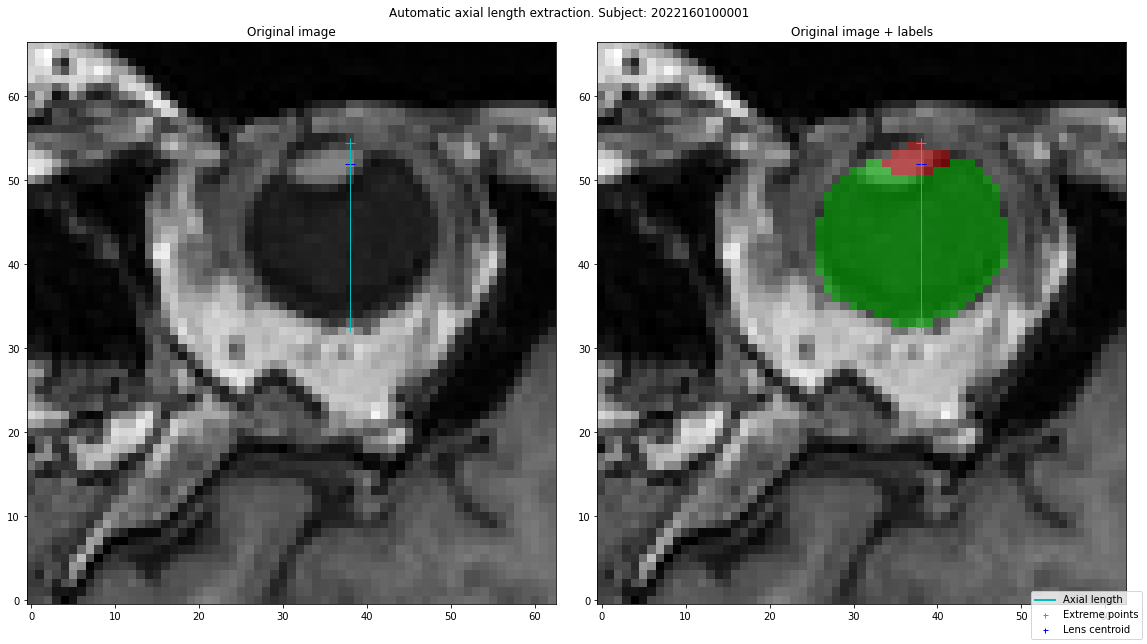

In [145]:
import os
import numpy as np
import nibabel as nb
from skimage.measure import regionprops, label
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D

METHOD = 'reg' # reg, dl, manual
LABEL = 'lens+globe' # eyeball, lens+globe

# Paths - segmentation results
if METHOD=='reg':
    main_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/'
    input_path = main_path + 'non_labeled_dataset_nifti_reg_2/'
    input_path_ima = main_path + 'non_labeled_dataset_nifti_cropped/'
elif METHOD=='dl':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
    input_path = main_path + 'test_orig_reg-cropped_non-labeled/'
elif METHOD=='manual':
    main_path = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/'
    input_path = main_path + 'a123/'
output_path = '/mnt/sda1/Repos/a-eye/Output/axial_length/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
axial_length_total = np.zeros(len_path)
outliers = list()

i=0
for folder1 in sorted(os.listdir(input_path)):

    # Load image in array format
    if METHOD=='reg':
        lab = nb.load(f'{input_path}{folder1}/labels.nii.gz')
        lab_arr = lab.get_fdata() # labels matrix
        voxel_size = lab.header.get_zooms() # voxel size
        ima = nb.load(f'{input_path_ima}{folder1}_cropped.nii.gz')
        ima_arr = ima.get_fdata() # image matrix
    elif METHOD=='dl':
        lab = nb.load(f'{input_path}{folder1}')
        lab_arr = lab.get_fdata() # labels matrix
        voxel_size = lab.header.get_zooms() # voxel size
    elif METHOD=='manual':
        lab = nb.load(f'{input_path}{folder1}/input/{folder1}_labels_cropped.nii.gz')
        lab_arr = lab.get_fdata() # labels matrix
        voxel_size = lab.header.get_zooms() # voxel size
    
    # Subject's name
    if METHOD=='reg' or METHOD=='manual': name_subject[i] = str(folder1)
    elif METHOD=='dl': name_subject[i] = folder1.split('_')[0]
    print(f'subject: {name_subject[i]}')

    # Label masks
    lens = (lab_arr==1)*1
    globe = (lab_arr==2)*1
    eyeball = (np.logical_or(lab_arr==1, lab_arr==2))*1 # *1 to convert it to int instead of bool
    if np.count_nonzero(lens)==0: outliers.append(name_subject[i])

    # PROPERTIES
    if LABEL == 'lens+globe':

        # LENS
        if np.count_nonzero(lens)!=0:
            properties_lens = regionprops(lens) # properties
            com_lens = properties_lens[0].centroid # centroid
            print(f'com_lens: {np.around(com_lens)}')
            axis_minor_lens = properties_lens[0].axis_minor_length # minor axis
            axis_major_lens = properties_lens[0].axis_major_length # major axis
            print(f'axis minor lens = {axis_minor_lens} \naxis major lens = {axis_major_lens}')
            orientation_lens = regionprops(lens[int(np.around(com_lens[0])), :, :])[0].orientation # orientation in 2D slice
            print(f'orientation lens = {orientation_lens}')
        else: axis_minor_lens = 0

        # GLOBE
        properties_globe = regionprops(globe) # properties
        com_globe = properties_globe[0].centroid # centroid
        print(f'com_globe: {np.around(com_globe)}')
        axis_minor_globe = properties_globe[0].axis_minor_length # minor axis
        axis_major_globe = properties_globe[0].axis_major_length # major axis
        print(f'axis minor globe = {axis_minor_globe} \naxis major globe = {axis_major_globe}')
        # orientation_globe = regionprops(globe[int(np.around(com_globe[0])), :, :])[0].orientation # orientation

        # AXIAL LENGTH
        axial_length = axis_minor_lens + axis_minor_globe
        print(f'axial length (axis_minor_lens + axis_minor_globe) = {np.around(axial_length, decimals=2)} mm')

    elif LABEL == 'eyeball':
        
        # EYEBALL
        properties_eyeball = regionprops(eyeball) # properties
        com_eyeball = properties_eyeball[0].centroid # centroid
        print(f'com_eyeball: {np.around(com_eyeball)}')
        axis_minor_eyeball = properties_eyeball[0].axis_minor_length # minor axis
        axis_major_eyeball = properties_eyeball[0].axis_major_length # major axis
        print(f'axis minor eyeball = {axis_minor_eyeball} \naxis major eyeball = {axis_major_eyeball}')
        # orientation_eyeball = regionprops(eyeball[int(np.around(com_eyeball[0])), :, :])[0].orientation # orientation

        # AXIAL LENGTH
        if np.count_nonzero(lens)!=0:
            axial_length = axis_major_eyeball
        else: axial_length = 0
        print(f'axial length eyeball = {np.around(axial_length, decimals=2)} mm')

    # Get the 2nd point of the orthogonal in the lens
    y0_lens = com_lens[1]
    z0_lens = com_lens[2]
    y1_lens = y0_lens - math.cos(0) * 0.5 * axis_minor_lens # orthogonal to the globe (following y axis: orientation y=1, z=0)
    z1_lens = z0_lens - math.sin(0) * 0.5 * axis_minor_lens

    # Parametric equation of the line between (y0, z0) and (y1, z1)
    n_points = int(np.ceil(math.dist([0,0], [lab_arr.shape[1], lab_arr.shape[2]]))) # max number of points of a line in the image square
    t = np.linspace(-int(n_points), int(n_points), n_points*10)
    line_y = (y0_lens - y1_lens)*t + y0_lens
    line_z = (z0_lens - z1_lens)*t + z0_lens

    # Line in image space (square)
    line = np.zeros([lab_arr.shape[1], lab_arr.shape[2]])
    for j in range(len(t)):
        if 0<=round(line_y[j])<lab_arr.shape[1] and 0<=round(line_z[j])<lab_arr.shape[2]:
            line[int(np.around(line_y[j])), int(np.around(line_z[j]))] = 1
    print(f'Number of points of the line in the image space: {np.count_nonzero(line)}')

    # Intersections and extreme points
    # Lens
    inter_lens = np.logical_and(lens[int(np.around(com_lens[0])),:,:], line)*1 # int format, intersection points in lens with line
    print(f'Number of instersection points in lens: {np.count_nonzero(inter_lens)}')
    inter_coord_lens = np.argwhere(inter_lens==1)
    extreme_inter_lens = inter_coord_lens[np.argmax(inter_coord_lens[:,0])]
    print(f'Lens extreme intersection point: {extreme_inter_lens}')
    # Globe
    inter_globe = np.logical_and(globe[int(np.around(com_lens[0])),:,:], line)*1 # int format, intersection points in globe with line
    print(f'Number of instersection points in globe: {np.count_nonzero(inter_globe)}')
    inter_coord_globe = np.argwhere(inter_globe==1)
    extreme_inter_globe = inter_coord_globe[np.argmin(inter_coord_globe[:,0])]
    print(f'Globe extreme intersection point: {extreme_inter_globe}')

    # Lens thickness
    lens_thickness = (extreme_inter_lens[0] + voxel_size[1]/2) - (y1_lens - voxel_size[1]/2)
    print(f'lens thickness = {lens_thickness}')

    # Line to compute the intensities gradient
    grad_arr = ima_arr[int(np.around(com_lens[0])), extreme_inter_lens[0]+1:lab_arr.shape[1]-1, extreme_inter_lens[1]]
    print(f'grad_arr = {grad_arr}')
    vox = 0
    if len(grad_arr) <= 1: vox=0
    else:
        for v in range(len(grad_arr)):
            next_val = grad_arr[v+1] if v != len(grad_arr)-1 else 3000
            if abs(next_val - grad_arr[v]) < 50: # no big difference
            # if grad_arr[v] > next_val:
                vox += 1
            else:
                break
    print(f'Number of mm to add to the axial length = {vox}')

    # Axial length
    axial_length = (extreme_inter_lens[0] + voxel_size[1]/2) - (extreme_inter_globe[0] - voxel_size[1]/2) + vox # distance between the center of the two points, we have to add +0.5mm for each point to be the actual extremes
    print(f'Axial length = {axial_length} mm')

    axial_length_total[i] = axial_length

    # if axial_length <= 21 or axial_length >= 27.5: outliers.append(name_subject[i])

    # PLOT
    k = 1 # aspect ratio
    fig, ax = plt.subplots(1, 2, figsize=(16*k, 9*k))
    fig.patch.set_facecolor('white')
    fig.suptitle(f'Automatic axial length extraction. Subject: {name_subject[i]}')

    # Legend
    legend_elements = [Line2D([0], [0], color='c', lw=2, label=f'Axial length'),
        Line2D([], [], color='c', label='Extreme points', marker='+', markersize=5, linestyle='None'),
        Line2D([], [], color='b', label='Lens centroid', marker='+', markersize=5, linestyle='None')]
    fig.legend(handles=legend_elements, loc='lower right')
    fig.tight_layout()

    # Lens centroid and line
    ax[0].set_title('Original image')
    ax[0].imshow(ima_arr[int(np.around(com_lens[0])),:,:], origin='lower', cmap='gist_gray', interpolation='none')
    # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
    ax[0].plot(int(np.around(com_lens[2])), int(np.around(com_lens[1])), '+b', markersize=10)
    ax[0].plot(extreme_inter_lens[1], extreme_inter_lens[0]+voxel_size[1]/2, '+c', markersize=10)
    ax[0].plot(extreme_inter_globe[1], extreme_inter_globe[0]-voxel_size[1]/2, '+c', markersize=10)
    ax[0].plot((extreme_inter_lens[1], extreme_inter_globe[1]), (extreme_inter_lens[0]+voxel_size[1]/2, extreme_inter_globe[0]-voxel_size[1]/2), '-c', linewidth=1)

    # Eyeball
    ax[1].set_title('Original image + labels')
    ax[1].imshow(ima_arr[int(np.around(com_lens[0])),:,:], origin='lower', cmap='gist_gray', interpolation='none')
    lens_mask = np.ma.masked_where(lens[int(np.around(com_lens[0])),:,:] == 0, lens[int(np.around(com_lens[0])),:,:])
    globe_mask = np.ma.masked_where(globe[int(np.around(com_lens[0])),:,:] == 0, globe[int(np.around(com_lens[0])),:,:])
    palette_lens = colors.ListedColormap(['red'])
    palette_globe = colors.ListedColormap(['lime'])
    ax[1].imshow(lens_mask, origin='lower', interpolation='none', alpha=0.4, cmap=palette_lens)
    ax[1].imshow(globe_mask, origin='lower', interpolation='none', alpha=0.4, cmap=palette_globe)
    # Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
    ax[1].plot(int(np.around(com_lens[2])), int(np.around(com_lens[1])), '+b', markersize=10)
    ax[1].plot(extreme_inter_lens[1], extreme_inter_lens[0]+voxel_size[1]/2, '+c', markersize=10)
    ax[1].plot(extreme_inter_globe[1], extreme_inter_globe[0]-voxel_size[1]/2, '+c', markersize=10)
    ax[1].plot((extreme_inter_lens[1], extreme_inter_globe[1]), (extreme_inter_lens[0]+voxel_size[1]/2, extreme_inter_globe[0]-voxel_size[1]/2), '-c', linewidth=1)

    plt.show()

    plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/axial_length/fig_{i}.png')

    i+=1
    if i==1:
        break

### Save values into .csv


In [55]:
import csv

if METHOD=='reg': filename = 'axial_length_reg_v2_grad_2.csv'
elif METHOD=='dl': filename = 'axial_length_dl_outliers.csv'
elif METHOD=='manual': filename = 'axial_length_manual.csv'

column_names = ['Subject','axial_length']
vals = np.array([name_subject, axial_length_total])
vals = vals.T
with open(output_path + filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(vals)

### Read values from .csv

1210
MANUAL: axial length mean: 23.1, std: 1.0391317611168285
ATLAS-BASED: axial length mean: 24.1, std: 0.9709662069601869
DEEP LEARNING: axial length mean: 23.0, std: 1.6397475332063318


<function matplotlib.pyplot.show(close=None, block=None)>

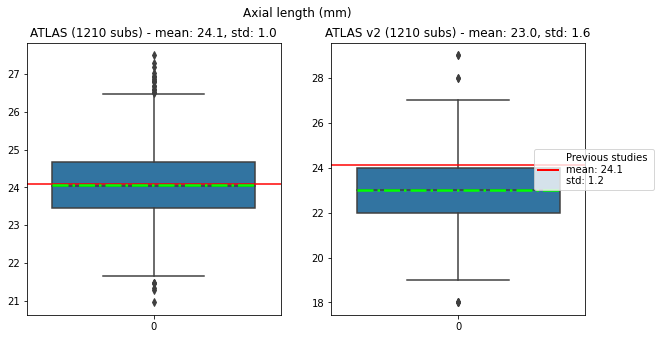

In [24]:
from turtle import color
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

ref_axl_mean = 24.1 # mm. Range: (21.6-27). See https://bmcophthalmol.biomedcentral.com/articles/10.1186/s12886-022-02289-y
ref_axl_std = 1.2 # mm

csv_manual = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/axial_length_manual.csv'
csv_reg = '/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_reg.csv'
# csv_dl = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/3D_multilabel/experiment_0/axial_length_dl_outliers.csv'
csv_dl = '/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_reg_v2_floor_min_axis.csv'

df_axial_manual = pd.read_csv(csv_manual)
df_axial_reg = pd.read_csv(csv_reg)
df_axial_dl = pd.read_csv(csv_dl)

# Data from .csv
axl_manual = np.array([df_axial_manual["axial_length"]])
axl_reg = np.array([df_axial_reg["axial_length"]])
axl_dl = np.array([df_axial_dl["axial_length"]])
axl_dl = axl_dl[axl_dl != 0]
print(len(axl_dl))
print(f'MANUAL: axial length mean: {np.around(np.mean(axl_manual), 1)}, std: {np.std(axl_manual)}\n\
ATLAS-BASED: axial length mean: {np.around(np.mean(axl_reg), 1)}, std: {np.std(axl_reg)}\n\
DEEP LEARNING: axial length mean: {np.around(np.mean(axl_dl), 1)}, std: {np.std(axl_dl)}')

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Axial length (mm)')
fig.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \nmean: {ref_axl_mean} \nstd: {ref_axl_std}')]
fig.legend(handles=legend_elements, loc='center right')

# # Manual
# ax[0].set_title(f'MANUAL (35 subs) - mean: {np.around(np.mean(axl_manual), decimals=1)}, std: {np.around(np.std(axl_manual), decimals=1)}')
# graph_lens = sns.boxplot(axl_manual, ax=ax[0])
# # graph_lens = sns.swarmplot(axl_manual, ax=ax[0])
# graph_lens.axhline(ref_axl_mean, color='red')
# # ax[0].set_xticklabels()
# if fix_axis:
#     # ax[0].set_xlim(x_axis)
#     ax[0].set_ylim(y_axis)

meanlineprops = dict(linestyle="-.", linewidth=2.5, color="lime")
meanpointprops = {"marker":"D", "markerfacecolor":"lime", "markeredgecolor":"black", "markersize":"10"}

# ATLAS-based reg
ax[0].set_title(f'ATLAS ({axl_reg.shape[1]} subs) - mean: {np.around(np.mean(axl_reg), decimals=1)}, std: {np.around(np.std(axl_reg), decimals=1)}')
graph_lens = sns.boxplot(axl_reg, ax=ax[0], meanprops=meanlineprops, showmeans=True, meanline=True)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# Deep learning
ax[1].set_title(f'ATLAS v2 ({len(axl_dl)} subs) - mean: {np.around(np.mean(axl_dl), decimals=1)}, std: {np.around(np.std(axl_dl), decimals=1)}')
graph_lens = sns.boxplot(axl_dl, ax=ax[1], meanprops=meanlineprops, showmeans=True, meanline=True)
graph_lens.axhline(ref_axl_mean, color='red')
if fix_axis:
    # ax[2].set_xlim(x_axis)
    ax[1].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/axial_length/boxplots_axial_length_v2_floor_min_axis.png')

## Metadata

Age, Sex, Height, Weight, BMI (= weight/height² [kg/m²])

In [ ]:
import SimpleITK as sitk
import sys, os, glob
import pydicomext as pydcm
from pydicom.fileset import FileSet
from deid.data import get_dataset
from deid.dicom import get_files, get_identifiers
from pathlib import Path

input_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/'

# List of volumes for each individual label and subject
len_path = len([elem for elem in os.listdir(input_path)])
name_subject = [None]*len_path
age_subject = [None]*len_path
sex_subject = [None]*len_path
height_subject = [None]*len_path
weight_subject = [None]*len_path
bmi_subject = [None]*len_path

# Create sorted list
i=0
list_subs = [None]*len_path
for folder1 in sorted(os.listdir(input_path)):
    list_subs[i] = folder1
    i+=1

# Start subloop from specific subject (0 if it's from the beginning)
index_sub = list_subs.index('2022160103683') # index_sub = 0 # if it's from the beginning
print(f'subject index: {index_sub}')

# Loop sublist
k=0
for j in range(index_sub, len_path):

    dicom_folder = f'{input_path}{list_subs[j]}/I_Kopf_t1_mpr_tra_iso_p2/'
    dicom_files = sorted(glob.glob(os.path.join(dicom_folder, "*.dcm")))
    ids = get_identifiers(dicom_files)

    # print(ids[dicom_files[0]].keys())

    # ID
    field_id = ids[dicom_files[0]]['(0010, 0020)']
    id = field_id.element.value
    name_subject[j] = id
    print(f'subject: {id}')

    # Sex
    field_sex = ids[dicom_files[0]]['(0010, 0040)']
    sex = field_sex.element.value
    sex_subject[j] = sex
    print(f'sex: {sex}')
    # name = field_sex.name
    # uid = field_sex.uid

    # Age
    field_age = ids[dicom_files[0]]['(0010, 1010)']
    age = field_age.element.value
    age = age[1:3]
    age_subject[j] = age
    print(f'age: {age}')

    # Height
    try:
        field_height = ids[dicom_files[0]]['(0010, 1020)']
        height = field_height.element.value
        height_subject[j] = height
    except KeyError:
        field_height = None
        height = None
        height_subject[j] = None
    print(f'height: {height} m')

    # Weight
    field_weight = ids[dicom_files[0]]['(0010, 1030)']
    weight = field_weight.element.value
    weight_subject[j] = weight
    print(f'weight: {weight} kg')

    # BMI (kg/m²)
    if height != None:
        bmi_subject[j] = weight / (height**2)
    print(f'BMI: {bmi_subject[j]} kg/m²')

    k+=1
    # if k==1:
    #     break

### Save values to .csv

In [35]:
import csv
import numpy as np

column_names = ['Subject','Sex','Age','Height','Weight','BMI']
vals = np.array([name_subject, sex_subject, age_subject, height_subject, weight_subject, bmi_subject])
vals = vals.T
vals = vals[index_sub:]

if index_sub != 0:
    # Reader
    with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'r') as read_file:
        reader = csv.reader(read_file)
        lines = list(reader)
        lines = lines[0:index_sub+1]
        lines.extend(list(vals))
# Writer
with open('/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv', 'w') as write_file:
    writer = csv.writer(write_file)
    if index_sub==0: # only writing columns if not starting from the first subject
        writer.writerow(column_names)
        lines = vals
    writer.writerows(lines)

read_file.close()
write_file.close()

### Read values from.csv

mean age is: 56.1, std: 13, min age is: 28, max age is: 89
men: 594, women: 616
- MALES (594): 
     BMI = 27.9 +- 3.7 kg/m² Underweight: 2; Non-overweight: 122; Overweight: 311; Obese: 159
- FEMALES (615): 
     BMI = 26.9 +- 4.7 kg/m² Underweight: 2; Non-overweight: 243; Overweight: 220; Obese: 150
- TOTAL (1209): 
     Underweight: 4; Non-overweight: 365; Overweight: 531; Obese: 309


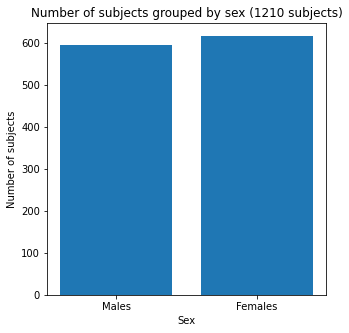

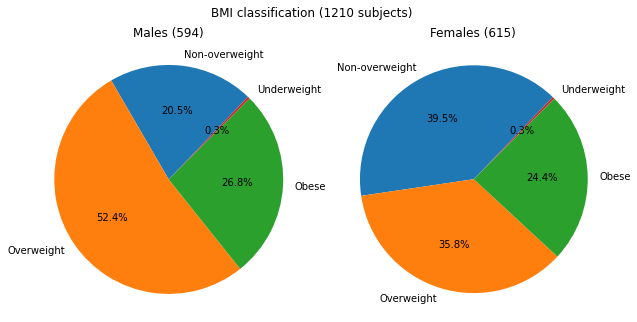

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

csv_file = '/mnt/sda1/Repos/a-eye/Output/sub_metadata.csv'
pd_csv = pd.read_csv(csv_file)

# Data from .csv
sex_csv = np.array([pd_csv["Sex"]], dtype='<U7')
age_csv = np.array([pd_csv["Age"]])
num_males = np.count_nonzero(np.char.count(sex_csv, "M"))
num_females = np.count_nonzero(np.char.count(sex_csv, "F"))

print(f'mean age is: {np.around(np.mean(age_csv), 1)}, std: {int(np.std(age_csv))}, min age is: {np.amin(age_csv)}, max age is: {np.amax(age_csv)}')
print(f'men: {num_males}, women: {num_females}')

# Sex group using pandas
sex_group = pd_csv.groupby(["Sex"], dropna=True)

# Print sex group
# for name, group in sex_group:
#     print(name)
#     print(group)

# Male group
male_group = sex_group.get_group("M").dropna() # group by male and remove NaN values
bmi_male = np.array([male_group["BMI"]])
mean_bmi_male = np.around(np.mean(bmi_male), decimals=1)
std_bmi_male = np.around(np.std(bmi_male), decimals=1)
underweight_male = np.count_nonzero(bmi_male<18.5)
non_overweight_male = np.count_nonzero(np.logical_and(18.5<=bmi_male, bmi_male<25))
overweight_male = np.count_nonzero(np.logical_and(25<=bmi_male, bmi_male<30))
obese_male = np.count_nonzero(bmi_male>=30)
print(f'- MALES ({male_group.shape[0]}): \n     BMI = {np.around(mean_bmi_male, 1)} +- {np.around(std_bmi_male, 1)} kg/m² \
Underweight: {underweight_male}; Non-overweight: {non_overweight_male}; Overweight: {overweight_male}; Obese: {obese_male}')

# Female group
female_group = sex_group.get_group("F").dropna() # group by female and remove NaN values (there is one that has no height)
bmi_female = np.array([female_group["BMI"]])
mean_bmi_female = np.around(np.mean(bmi_female), decimals=1)
std_bmi_female = np.around(np.std(bmi_female), decimals=1)
underweight_female = np.count_nonzero(bmi_female<18.5)
non_overweight_female = np.count_nonzero(np.logical_and(18.5<=bmi_female, bmi_female<25))
overweight_female = np.count_nonzero(np.logical_and(25<=bmi_female, bmi_female<30))
obese_female = np.count_nonzero(bmi_female>=30)
print(f'- FEMALES ({female_group.shape[0]}): \n     BMI = {np.around(mean_bmi_female, 1)} +- {np.around(std_bmi_female, 1)} kg/m² \
Underweight: {underweight_female}; Non-overweight: {non_overweight_female}; Overweight: {overweight_female}; Obese: {obese_female}')

# Total
print(f'- TOTAL ({male_group.shape[0] + female_group.shape[0]}): \n     Underweight: {underweight_female + underweight_male}; \
Non-overweight: {non_overweight_female + non_overweight_male}; Overweight: {overweight_female + overweight_male}; \
Obese: {obese_female + obese_male}')


# PLOT #

# Sex
fig1 = plt.figure(figsize=(5,5))
fig1.patch.set_facecolor('white')
plt.bar(('Males', 'Females'), (num_males, num_females))
plt.xlabel('Sex')
plt.ylabel('Number of subjects')
plt.title(f'Number of subjects grouped by sex ({num_males+num_females} subjects)')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/sex_bargraph.png')

# Age
age_counts = pd_csv["Age"].value_counts()
fig2 = px.bar(age_counts, title=f'Distribution of age ({num_males+num_females} subjects)')
fig2.update_layout(
    xaxis_title = 'Age',
    yaxis_title = 'Frequency',
    title_x = 0.5,
    showlegend = False
)
fig2.show()
fig2.write_image('/mnt/sda1/Repos/a-eye/Output/age_bargraph.png')

# BMI
bmi_labels = ('Underweight', 'Non-overweight', 'Overweight', 'Obese')
bmi_percentages_male = np.array([underweight_male, non_overweight_male, overweight_male, obese_male]) / male_group.shape[0]
bmi_percentages_female = np.array([underweight_female, non_overweight_female, overweight_female, obese_female]) / female_group.shape[0]
bmi_colors = ('tab:red','tab:blue','tab:orange','tab:green')
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 5))
fig3.patch.set_facecolor('white')
fig3.suptitle(f'BMI classification ({num_males+num_females} subjects)')
axs3[0].pie(bmi_percentages_male, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[0].axis('equal'), axs3[0].set_title(f'Males ({male_group.shape[0]})')
axs3[1].pie(bmi_percentages_female, labels=bmi_labels, startangle=45, colors=bmi_colors, autopct='%1.1f%%')
axs3[1].axis('equal'), axs3[1].set_title(f'Females ({female_group.shape[0]})')
plt.show()
# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_piechart.png')


## Axial length grouped by sex

In [60]:
import pandas as pd
import numpy as np

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_axial_length = '/mnt/sda1/Repos/a-eye/Output/axial_length/axial_length_reg_v2_grad_2.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_axial_length = pd.read_csv(csv_axial_length)

# Dataframe
# df = pd.concat((pd_metadata, pd_axial_length), ignore_index=False) # concatenates one after the other
df = pd.concat([pd_metadata, pd_axial_length['axial_length']], axis=1, verify_integrity=True)

# Group by sex
sex_group = df.groupby(["Sex"])

# Male group
male_group = sex_group.get_group("M").dropna() 
axial_length_male = np.array([male_group["axial_length"]])
mean_al_male = np.around(np.mean(axial_length_male), decimals=1)
std_al_male = np.around(np.std(axial_length_male), decimals=1)
print(f'- MALES: \n   Axial length: {mean_al_male} +- {std_al_male} mm')

# Female group
female_group = sex_group.get_group("F").dropna() 
axial_length_female = np.array([female_group["axial_length"]])
mean_al_female = np.around(np.mean(axial_length_female), decimals=1)
std_al_female = np.around(np.std(axial_length_female), decimals=1)
print(f'- FEMALES: \n   Axial length: {mean_al_female} +- {std_al_female} mm')

- MALES: 
   Axial length: 21.1 +- 1.5 mm
- FEMALES: 
   Axial length: 20.3 +- 1.5 mm


### Plot

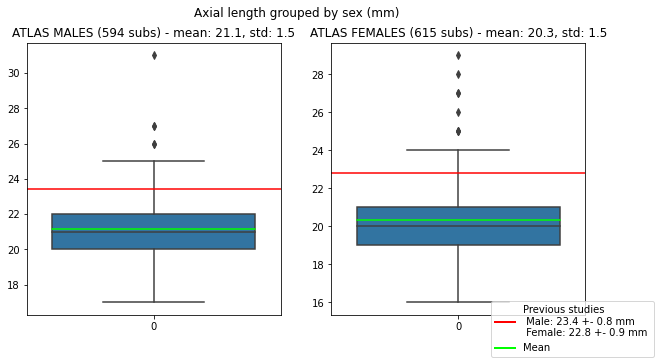

In [61]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Literature (PlosOne Sönke). See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6366780/
ref_axl_male_mean = 23.4 # mm
ref_axl_male_std = 0.8 # mm
ref_axl_female_mean = 22.8 # mm
ref_axl_female_std = 0.9 # mm

# Subplots
k = 1 # Figure size to preserve ratio 16:9
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Axial length grouped by sex (mm)')
fig.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Previous studies \n Male: {ref_axl_male_mean} +- {ref_axl_male_std} mm \
    \n Female: {ref_axl_female_mean} +- {ref_axl_female_std} mm'),
    Line2D([0], [0], color='lime', lw=2, label='Mean')]
fig.legend(handles=legend_elements, loc='lower right')
meanlineprops = dict(linestyle="solid", linewidth=1.5, color="lime")
meanpointprops = {"marker":"D", "markerfacecolor":"lime", "markeredgecolor":"black", "markersize":"10"}

# ATLAS - MALES
ax[0].set_title(f'ATLAS MALES ({male_group.shape[0]} subs) - mean: {mean_al_male}, std: {std_al_male}')
graph_lens = sns.boxplot(axial_length_male, ax=ax[0], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_male_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

# ATLAS - FEMALES
ax[1].set_title(f'ATLAS FEMALES ({female_group.shape[0]} subs) - mean: {mean_al_female}, std: {std_al_female}')
graph_lens = sns.boxplot(axial_length_female, ax=ax[1], meanprops=meanlineprops, meanline=True, showmeans=True)
graph_lens.axhline(ref_axl_female_mean, color='red')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax[0].set_ylim(y_axis)

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/axial_length/boxplots_axial_length_v2_grad_2.png')

## Volumetry and BMI

Concatenate csv's and group by sex

In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

# Concat csv in one dataframe (metadata + volumes per label)

# Paths
csv_metadata = '/mnt/sda1/Repos/a-eye/Output/metadata/sub_metadata.csv'
csv_volumes = '/mnt/sda1/Repos/a-eye/Output/volumes/volumes_reg.csv'

# Pandas read csv
pd_metadata = pd.read_csv(csv_metadata)
pd_volumes= pd.read_csv(csv_volumes)

# Dataframe
df = pd.concat([pd_metadata, pd_volumes.iloc[:, 1:]], axis=1, verify_integrity=True)

# Group by sex (males and females)
sex_group = df.groupby(["Sex"], dropna=True)

### Scatter plots

Males

<function matplotlib.pyplot.show(close=None, block=None)>

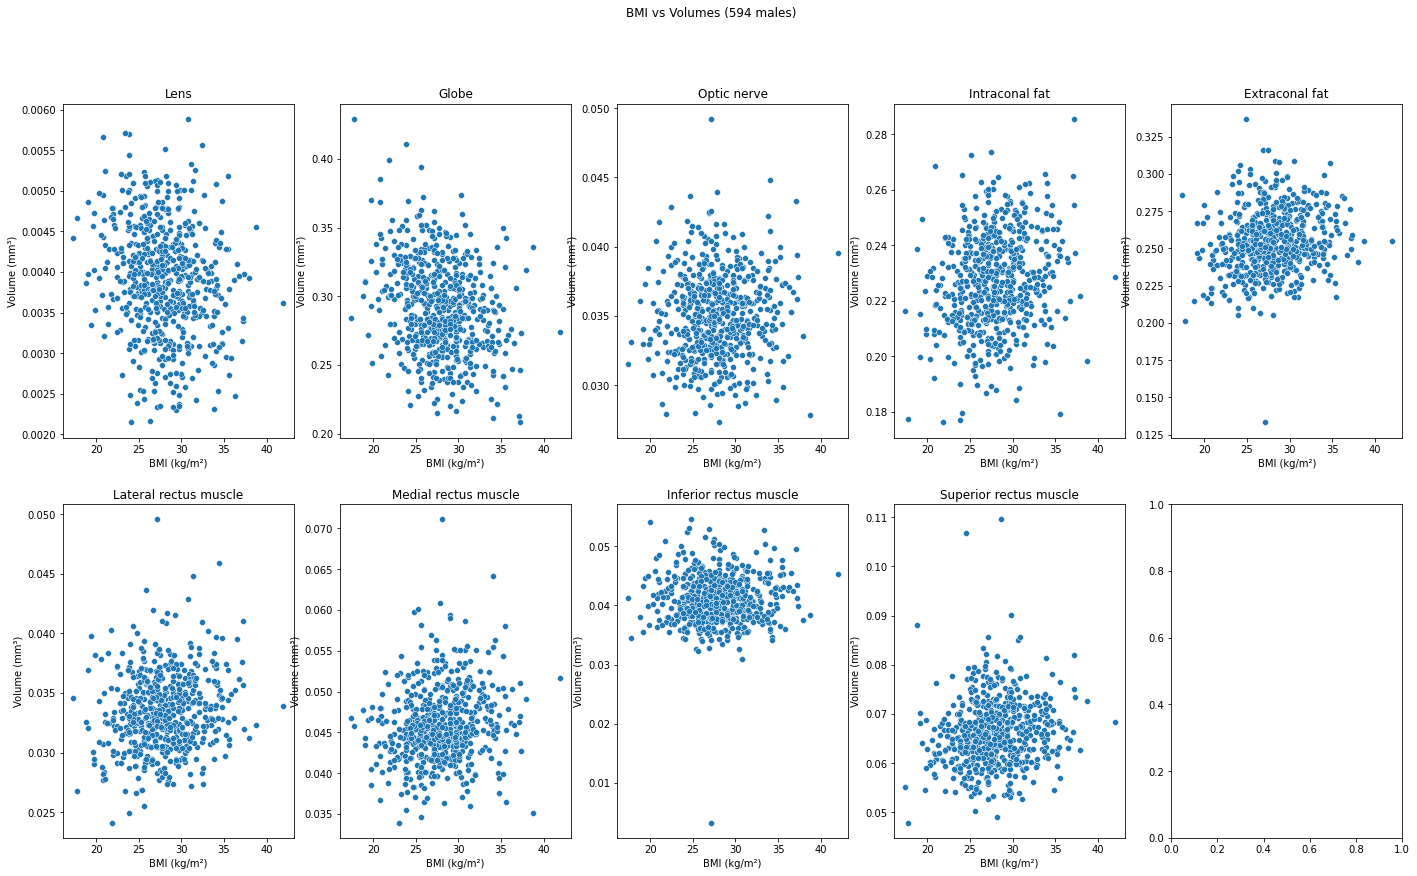

In [91]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Females

<function matplotlib.pyplot.show(close=None, block=None)>

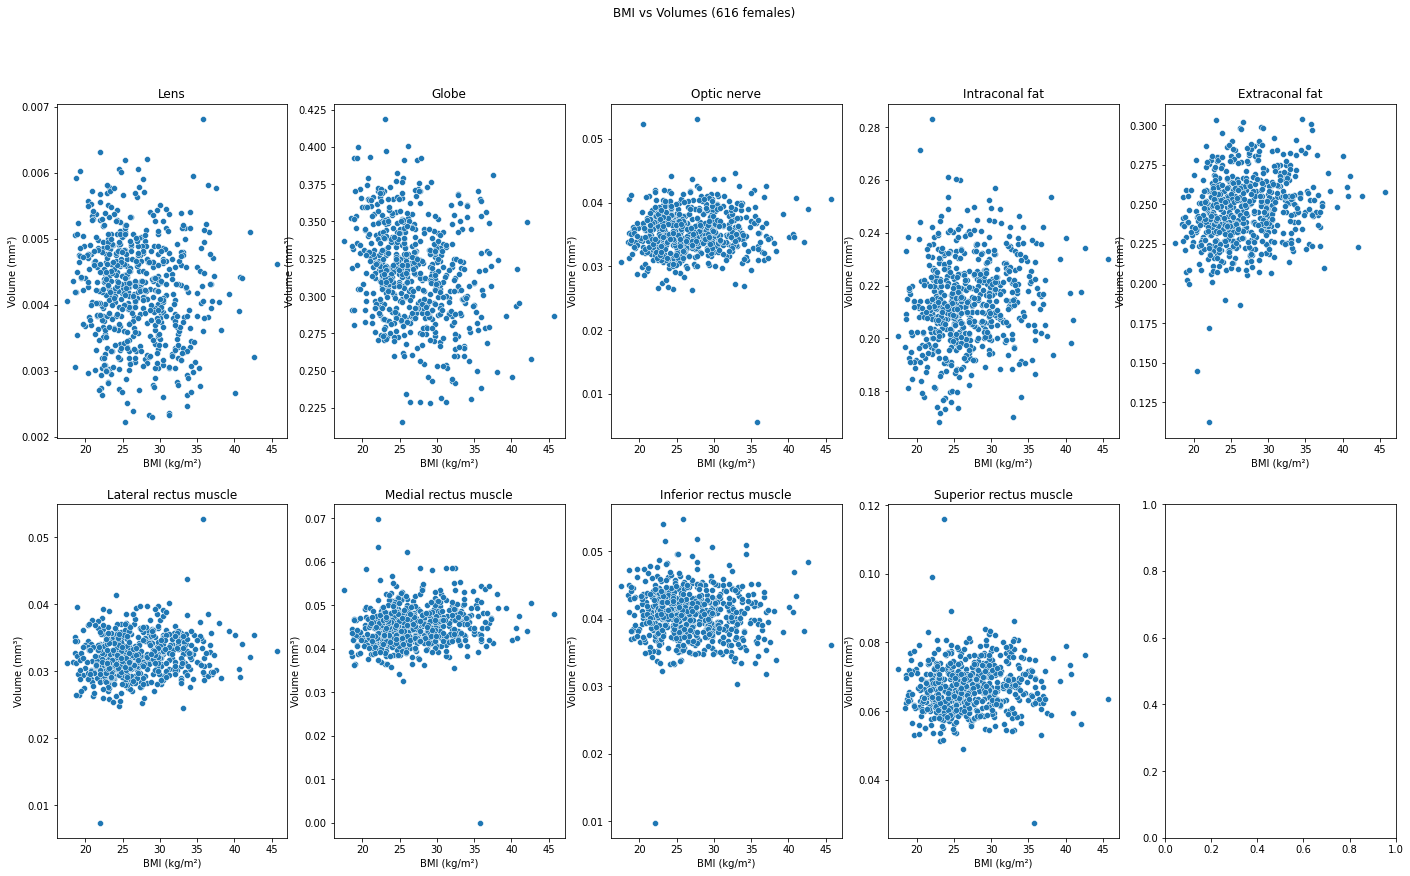

In [3]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig2, ax2 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig2.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig2.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax2[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax2[0][0])
ax2[0][0].set_xlabel('BMI (kg/m²)')
ax2[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][0].set_ylim(y_axis)

# Globe
ax2[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax2[0][1])
ax2[0][1].set_xlabel('BMI (kg/m²)')
ax2[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][1].set_ylim(y_axis)

# Optic nerve
ax2[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax2[0][2])
ax2[0][2].set_xlabel('BMI (kg/m²)')
ax2[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][2].set_ylim(y_axis)

# Intraconal fat
ax2[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax2[0][3])
ax2[0][3].set_xlabel('BMI (kg/m²)')
ax2[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][3].set_ylim(y_axis)

# Extraconal fat
ax2[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax2[0][4])
ax2[0][4].set_xlabel('BMI (kg/m²)')
ax2[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax2[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax2[1][0])
ax2[1][0].set_xlabel('BMI (kg/m²)')
ax2[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax2[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax2[1][1])
ax2[1][1].set_xlabel('BMI (kg/m²)')
ax2[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax2[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax2[1][2])
ax2[1][2].set_xlabel('BMI (kg/m²)')
ax2[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax2[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax2[1][3])
ax2[1][3].set_xlabel('BMI (kg/m²)')
ax2[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax2[1][3].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_females_norm.png')

### Check normal distribution

#### MALES

Graph

/tmp/ipykernel_243210/1212976245.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot1 = sns.distplot(volume_lens_male.flatten(), ax=ax1[0][0])
/tmp/ipykernel_243210/1212976245.py:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot2 = sns.distplot(volume_globe_male.flatten(), ax=ax1[0][1])
/tmp/ipykernel_243210/1

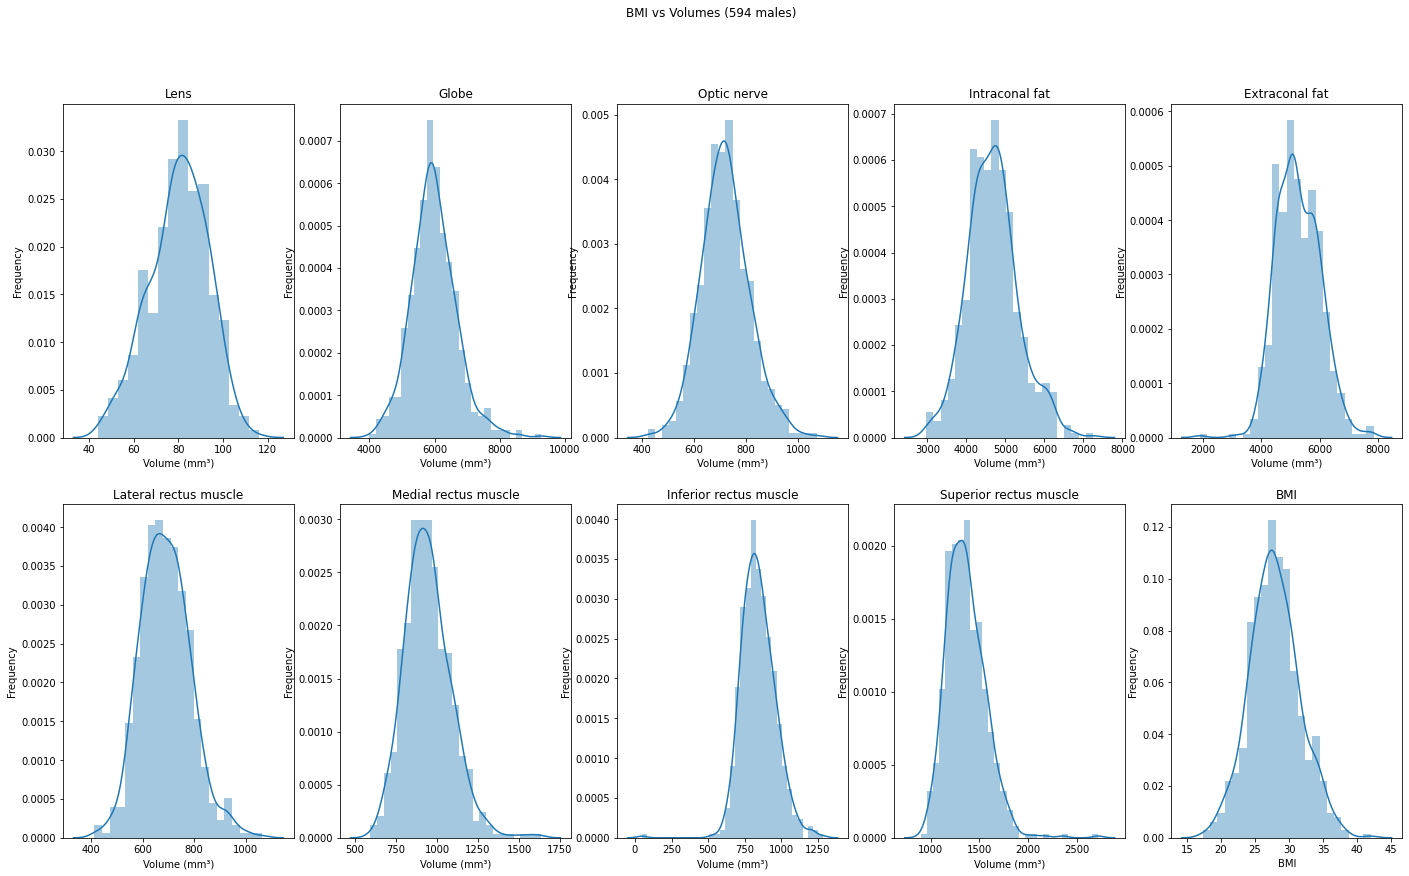

In [92]:
# Male group
male_group = sex_group.get_group("M").dropna()

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_male.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_male.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_male.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_male.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_male.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_male.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_male.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_male.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_male.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_male.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show

plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_males.png')

Shapiro-Wilk test

In [102]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_male.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_male.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_male.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_male.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_male.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_male.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_male.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_male.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_male.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_male.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

LENS 
stats = 0.990807 p_value = 0.000931233
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
GLOBE 
stats = 0.981014 p_value = 5.62968e-07
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
OPTIC NERVE 
stats = 0.9935789108276367 p_value = 0.0124753
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
INTRACONAL FAT 
stats = 0.9879765510559082 p_value = 8.44063e-05
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
EXTRACONAL FAT 
stats = 0.9876975417137146 p_value = 6.74869e-05
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
LATERAL RECTUS MUSCLE 
stats = 0.9904671907424927 p_value = 0.000688666
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
MEDIAL RECTUS MUSCLE 
stats = 0.9728270769119263 p_value = 4.82662e-09
The null hypothesis can be rejected --> The set may NOT follow a n

#### FEMALES

Graph

/tmp/ipykernel_243210/2828739335.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot1 = sns.distplot(volume_lens_female.flatten(), ax=ax1[0][0])
/tmp/ipykernel_243210/2828739335.py:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot2 = sns.distplot(volume_globe_female.flatten(), ax=ax1[0][1])
/tmp/ipykernel_2432

<function matplotlib.pyplot.show(close=None, block=None)>

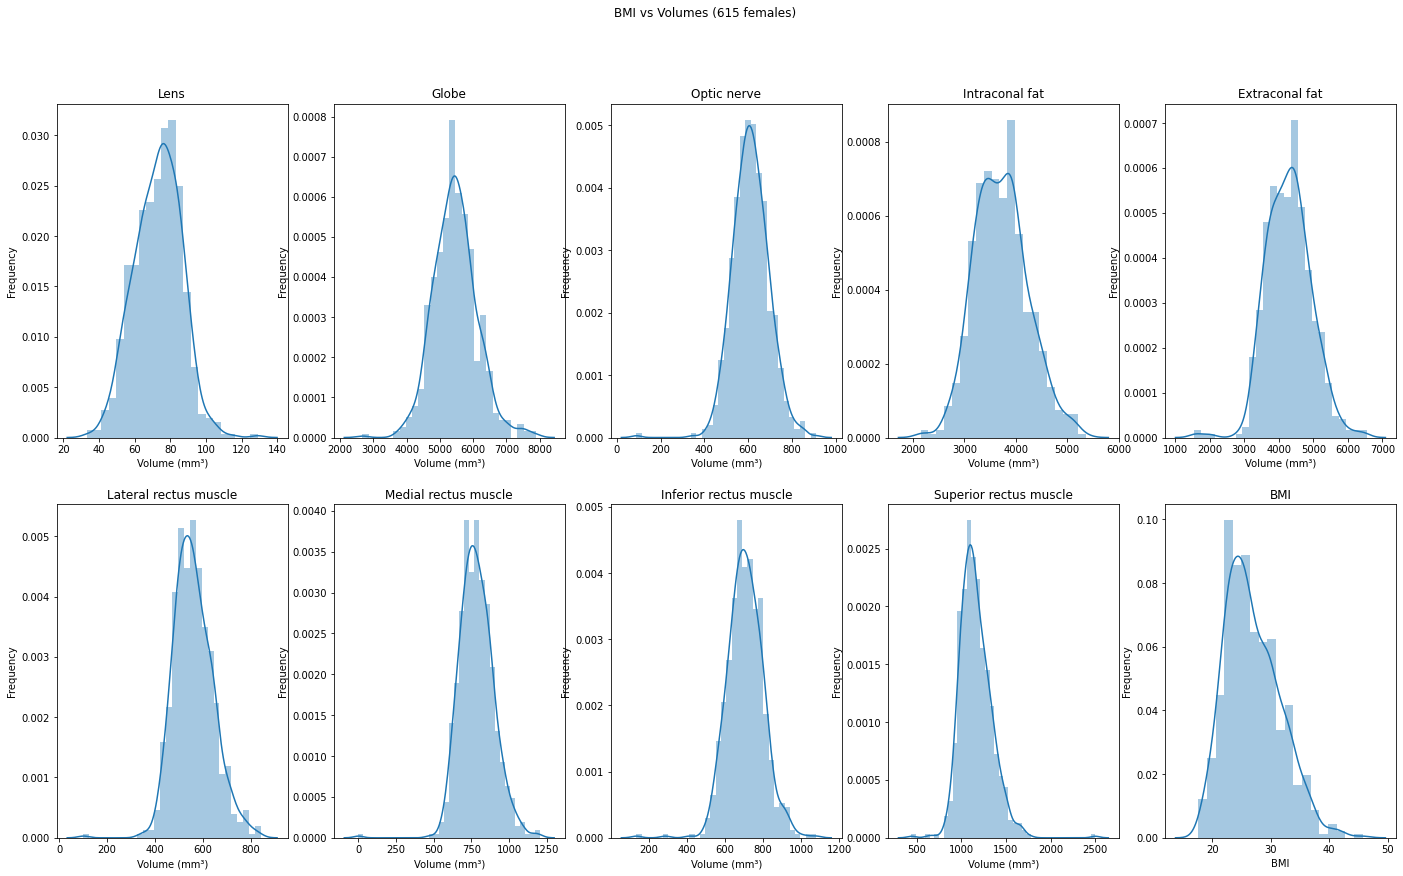

In [104]:
# Female group
female_group = sex_group.get_group("F").dropna()

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.distplot(volume_lens_female.flatten(), ax=ax1[0][0])
ax1[0][0].set_xlabel('Volume (mm³)')
ax1[0][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.distplot(volume_globe_female.flatten(), ax=ax1[0][1])
ax1[0][1].set_xlabel('Volume (mm³)')
ax1[0][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.distplot(volume_nerve_female.flatten(), ax=ax1[0][2])
ax1[0][2].set_xlabel('Volume (mm³)')
ax1[0][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.distplot(volume_int_fat_female.flatten(), ax=ax1[0][3])
ax1[0][3].set_xlabel('Volume (mm³)')
ax1[0][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.distplot(volume_ext_fat_female.flatten(), ax=ax1[0][4])
ax1[0][4].set_xlabel('Volume (mm³)')
ax1[0][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.distplot(volume_lat_mus_female.flatten(), ax=ax1[1][0])
ax1[1][0].set_xlabel('Volume (mm³)')
ax1[1][0].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.distplot(volume_med_mus_female.flatten(), ax=ax1[1][1])
ax1[1][1].set_xlabel('Volume (mm³)')
ax1[1][1].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.distplot(volume_inf_mus_female.flatten(), ax=ax1[1][2])
ax1[1][2].set_xlabel('Volume (mm³)')
ax1[1][2].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot9 = sns.distplot(volume_sup_mus_female.flatten(), ax=ax1[1][3])
ax1[1][3].set_xlabel('Volume (mm³)')
ax1[1][3].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][4].set_title(f'BMI')
plot10 = sns.distplot(bmi_female.flatten(), ax=ax1[1][4])
ax1[1][4].set_xlabel('BMI')
ax1[1][4].set_ylabel('Frequency')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][4].set_ylim(y_axis)

plt.show

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/dist_gaussian_vol_bmi_females.png')

Shapiro-Wilk test

In [101]:
from scipy import stats

alpha = 0.05

# LENS
statistic, p_value = stats.shapiro(volume_lens_female.flatten())
print(f"LENS \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# GLOBE
statistic, p_value = stats.shapiro(volume_globe_female.flatten())
print(f"GLOBE \nstats = {statistic:g} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# OPTIC NERVE
statistic, p_value = stats.shapiro(volume_nerve_female.flatten())
print(f"OPTIC NERVE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INTRACONAL FAT
statistic, p_value = stats.shapiro(volume_int_fat_female.flatten())
print(f"INTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# EXTRACONAL FAT
statistic, p_value = stats.shapiro(volume_ext_fat_female.flatten())
print(f"EXTRACONAL FAT \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# LATERAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_lat_mus_female.flatten())
print(f"LATERAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# MEDIAL RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_med_mus_female.flatten())
print(f"MEDIAL RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# SUPERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_sup_mus_female.flatten())
print(f"SUPERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# INFERIOR RECTUS MUSCLE
statistic, p_value = stats.shapiro(volume_inf_mus_female.flatten())
print(f"INFERIOR RECTUS MUSCLE \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

# BMI
statistic, p_value = stats.shapiro(bmi_female.flatten())
print(f"BMI \nstats = {statistic} p_value = {p_value:g}")
if p_value < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected --> The set may NOT follow a normal distribution")
else:
    print("The null hypothesis cannot be rejected --> The set may follow a normal distribution")

LENS 
stats = 0.994358 p_value = 0.0223105
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
GLOBE 
stats = 0.98636 p_value = 1.66519e-05
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
OPTIC NERVE 
stats = 0.9804466366767883 p_value = 2.5386e-07
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
INTRACONAL FAT 
stats = 0.9927892088890076 p_value = 0.00461741
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
EXTRACONAL FAT 
stats = 0.9850305914878845 p_value = 6.06377e-06
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
LATERAL RECTUS MUSCLE 
stats = 0.9777147769927979 p_value = 4.63097e-08
The null hypothesis can be rejected --> The set may NOT follow a normal distribution
MEDIAL RECTUS MUSCLE 
stats = 0.9667865037918091 p_value = 1.40687e-10
The null hypothesis can be rejected --> The set may NOT follow a norm

### Linear regression

In [147]:
train_test = False
remove_outliers = False

#### Males

Prepare data

In [30]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# columns = ['vol_lens']
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train[columns].shape)
print(test.shape)

(475, 9)
(119, 15)


P values

In [31]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

# print(f'p_value = {p_values}')
print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

p_values 
 Lens: 0.8507090604509476 
 Globe: 0.4048564133216336 
 Optic nerve: 2.0965167687018447e-09 
 Intraconal fat: 8.204304598742781e-11     
 Extraconal fat: 2.357045516106221e-10 
 Lateral rectus muscle: 4.0590284922039004e-13 
 Medial rectus muscle: 1.3174427076988595e-10     
 Inferior rectus muscle: 1.5730344942507433e-05 
 Superior rectus muscle: 1.9915439377592266e-10


Train

In [32]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

R² score = 0.13300851462537577 
Intercept = 16.900855532200204 
Slope = [ 5.05651702e-03  7.40759046e-05  2.38756999e-03 -3.01125717e-04
  1.21853964e-04  8.75559257e-03  3.06124672e-03 -3.33509991e-03
  2.26233852e-03]


Test

In [33]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Root mean squared error:  3.384712157444931
Variance score (R²-score): 0.15


Plot

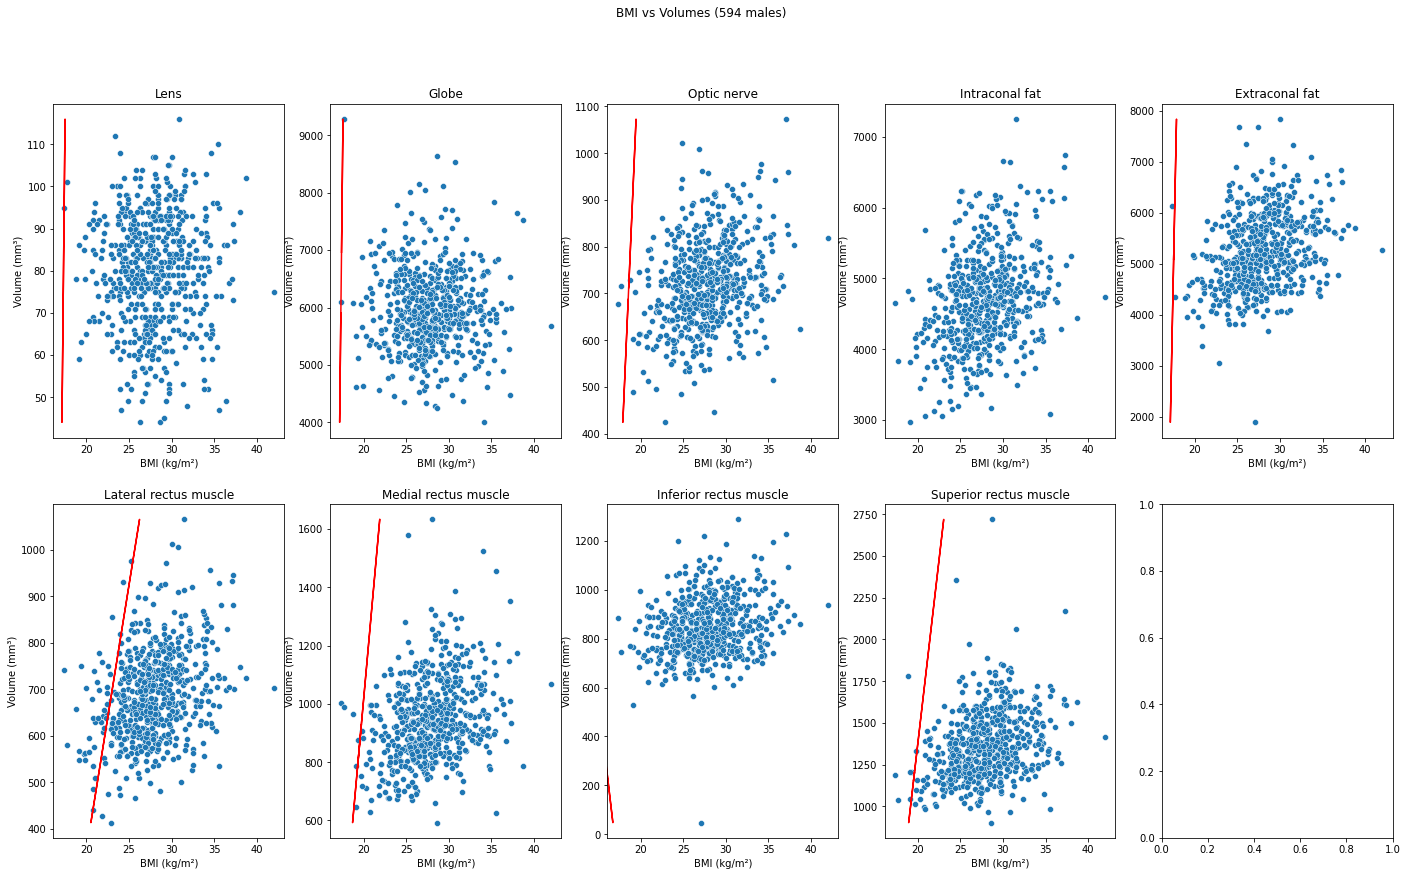

In [34]:
# Male group
male_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lens_male.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_male.flatten()))
line = Line2D(line_points, volume_lens_male.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_male.flatten(), y=volume_globe_male.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_male.flatten()))
line = Line2D(line_points, volume_globe_male.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_male.flatten(), y=volume_nerve_male.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_male.flatten()))
line = Line2D(line_points, volume_nerve_male.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_male.flatten(), y=volume_int_fat_male.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_male.flatten()))
line = Line2D(line_points, volume_int_fat_male.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_male.flatten(), y=volume_ext_fat_male.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_male.flatten()))
line = Line2D(line_points, volume_ext_fat_male.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_male.flatten(), y=volume_lat_mus_male.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_male.flatten()))
line = Line2D(line_points, volume_lat_mus_male.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_male.flatten(), y=volume_med_mus_male.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_male.flatten()))
line = Line2D(line_points, volume_med_mus_male.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_inf_mus_male.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_male.flatten()))
line = Line2D(line_points, volume_inf_mus_male.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_male.flatten(), y=volume_sup_mus_male.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_male.flatten()))
line = Line2D(line_points, volume_sup_mus_male.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

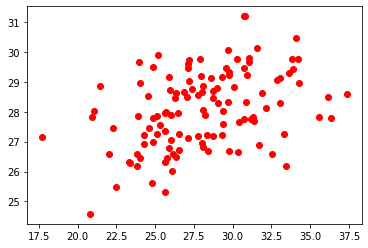

In [35]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

MALES 

Train shape: (594, 9)
Test shape: (0, 15) 

Lens
Shape before removing outliers = (594, 2)
Shape after removing outliers = (594, 2)
Slope = 0.001164026576442781 
Intercept = 27.815463552958928 
R value = 0.004144776280181494 
P value = 0.9197055639719585 
Stderr = 0.011542429173288444 

Globe
Shape before removing outliers = (594, 2)
Shape after removing outliers = (594, 2)
Slope = 2.1827701314718213e-05 
Intercept = 27.778179393881214 
R value = 0.004091396450766651 
P value = 0.9207362394877284 
Stderr = 0.0002192663311847128 

Optic nerve
Shape before removing outliers = (594, 2)
Shape after removing outliers = (594, 2)
Slope = 0.01145175222196945 
Intercept = 19.645213852967373 
R value = 0.28592138789311666 
P value = 1.2240060902404014e-12 
Stderr = 0.0015774102867962278 

Intraconal fat
Shape before removing outliers = (594, 2)
Shape after removing outliers = (594, 2)
Slope = 0.0018218813640056405 
Intercept = 19.378823059699663 
R value = 0.3224665718347784 
P value = 7

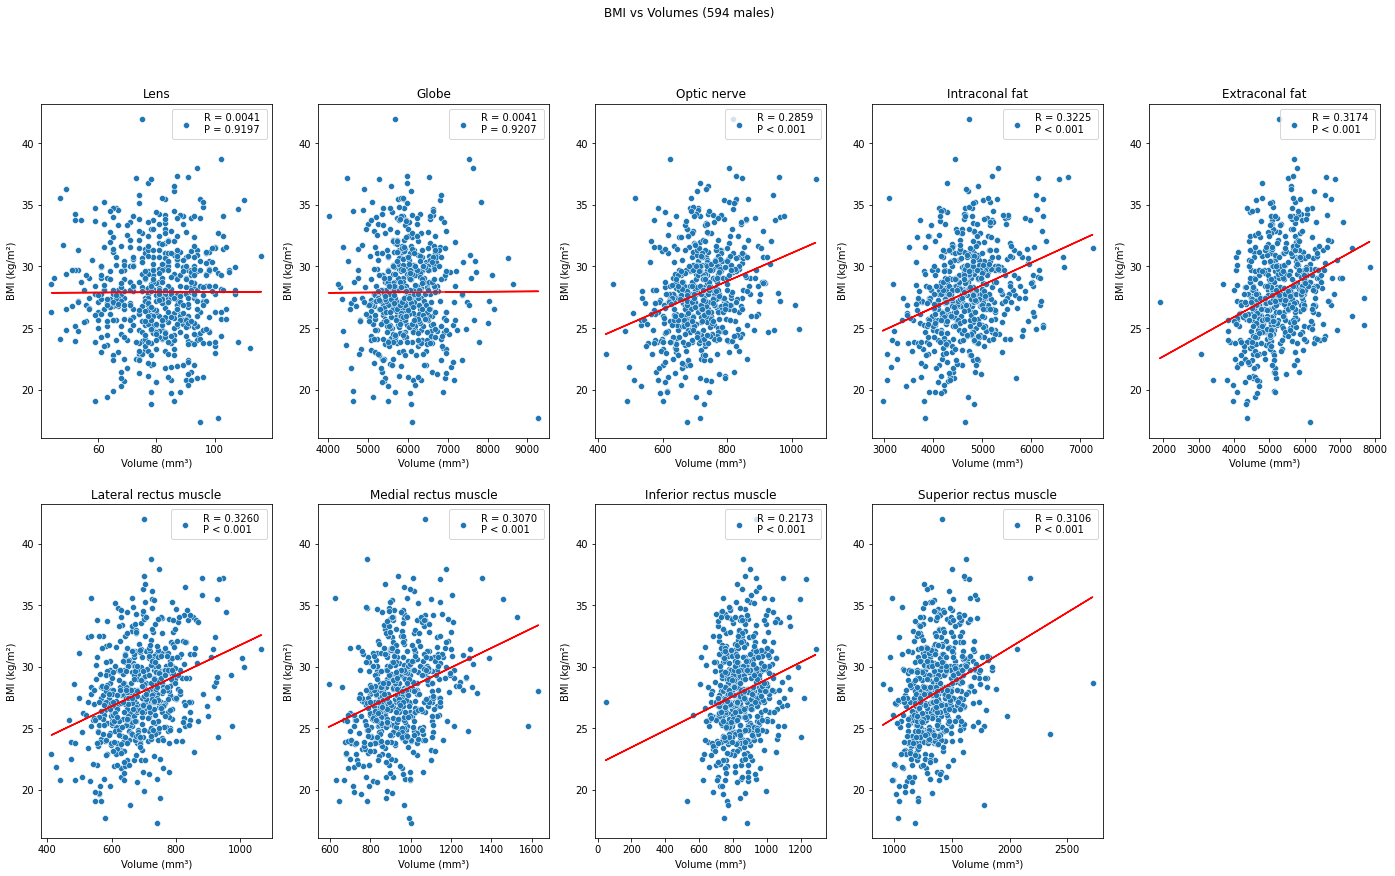

In [160]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score
# Correlations
from scipy import stats

# Male group
male_group = sex_group.get_group("M").dropna()
print('MALES \n')

# Get all the columns from the dataframe.
columns = male_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = male_group.sample(frac=0.8, random_state=1)
else: train = male_group

# Select anything not in the training set and put it in the testing set.
test = male_group.loc[~male_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
# model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_male = np.array([male_group["vol_lens"]])
volume_globe_male = np.array([male_group["vol_globe"]])
volume_nerve_male = np.array([male_group["vol_nerve"]])
volume_int_fat_male = np.array([male_group["vol_int_fat"]])
volume_ext_fat_male = np.array([male_group["vol_ext_fat"]])
volume_lat_mus_male = np.array([male_group["vol_lat_mus"]])
volume_med_mus_male = np.array([male_group["vol_med_mus"]])
volume_inf_mus_male = np.array([male_group["vol_inf_mus"]])
volume_sup_mus_male = np.array([male_group["vol_sup_mus"]])
volumes_male_list = np.array([volume_lens_male, volume_globe_male, volume_nerve_male, volume_int_fat_male, volume_ext_fat_male,
    volume_lat_mus_male, volume_med_mus_male, volume_inf_mus_male, volume_sup_mus_male])

# BMI
bmi_male = np.array([male_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(16*k, 9*k))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({male_group.shape[0]} males)')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove outliers
    if remove_outliers == True:
        # Vol
        mean_vol = np.mean(arr[:,0])
        std_vol = np.std(arr[:,0])
        # Vol: mean - 2*std
        index_low_vol = list(np.array(np.where(arr[:,0] < (mean_vol - 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_vol, axis=0) # delete rows from array
        # Vol: mean + 2*std
        index_up_vol = list(np.array(np.where(arr[:,0] > (mean_vol + 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_vol, axis=0) # delete rows from array
        # BMI
        mean_bmi = np.mean(arr[:,1])
        std_bmi = np.std(arr[:,1])
        # BMI: mean - 2*std
        index_low_bmi = list(np.array(np.where(arr[:,1] < (mean_bmi - 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_bmi, axis=0) # delete rows from array
        # BMI: mean + 2*std
        index_up_bmi = list(np.array(np.where(arr[:,1] > (mean_bmi + 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_bmi, axis=0) # delete rows from array

    print(f'Shape after removing outliers = {arr.shape}')

    # Linear regression
    result = stats.linregress(arr)
    slope = result.slope
    intercept = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope = {slope} \nIntercept = {intercept} \nR value = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line(x):
        return slope * x + intercept

    # Plot
    ax = plt.subplot(2, 5, n+1) # add a new subplot iteratively
    sns.scatterplot(y=bmi_male.flatten(), x=volumes_male_list[n].flatten(), ax=ax)
    line_points = list(map(get_line, volumes_male_list[n].flatten()))
    line = Line2D(volumes_male_list[n].flatten(), line_points, color='red')
    ax.add_line(line)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    p_value_plot = f'= {p_value:.4f}' if p_value >= 0.001 else '< 0.001'
    labels = [f'R = {r_value:.4f} \nP {p_value_plot}']
    ax.legend(labels=labels, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_males_linear_regression_outliers_mean' if remove_outliers else 'bmi_vs_volume_males_linear_regression'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/{filename}_inv.png')

#### Females

Prepare data

In [51]:
# Female group
female_group = sex_group.get_group("F").dropna() 

# # Splitting into train and test sets

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI"]]

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group    

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(train.shape)
print(test.shape)

(615, 15)
(0, 15)


P values

In [52]:
from sklearn.feature_selection import f_regression

ALPHA = 0.05
f_statistics, p_values = f_regression(train[columns], train[target]) # volumes with BMI

print(f'p_values \n Lens: {p_values[0]} \n Globe: {p_values[1]} \n Optic nerve: {p_values[2]} \n Intraconal fat: {p_values[3]} \
    \n Extraconal fat: {p_values[4]} \n Lateral rectus muscle: {p_values[5]} \n Medial rectus muscle: {p_values[6]} \
    \n Inferior rectus muscle: {p_values[7]} \n Superior rectus muscle: {p_values[8]}')

p_values 
 Lens: 1.6349409031679305e-06 
 Globe: 0.59002783540285 
 Optic nerve: 0.8593355850007262 
 Intraconal fat: 1.2478124829973483e-11     
 Extraconal fat: 1.0267266756955912e-14 
 Lateral rectus muscle: 6.578469334180613e-17 
 Medial rectus muscle: 1.116709463973918e-15     
 Inferior rectus muscle: 5.257070626767507e-15 
 Superior rectus muscle: 3.9693703770127916e-05


Train

In [53]:
# Fitting a linear regression

# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma

# Initialize the model class.
model = linear_model.LinearRegression()
# model = linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data.
trained_model = model.fit(train[columns], train[target])

# Model score, intercept and  slope
intercept = trained_model.intercept_
slope = trained_model.coef_
print(f'R² score = {trained_model.score(train[columns], train[target])} \nIntercept = {intercept} \nSlope = {slope}')

R² score = 0.1819077644073901 
Intercept = 12.641136122791552 
Slope = [ 0.04333462  0.03203285 -0.00033473  0.00256266  0.00060278  0.00133187
  0.00827174  0.00881703 -0.01343376 -0.00023769]


Test

In [54]:
# Predicting Error

# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

if train_test:
    # Generate our predictions for the test set.
    predictions = model.predict(test[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, test[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(test[target], predictions))
else:
    # Generate our predictions for the test set.
    predictions = model.predict(train[columns])

    # Compute error between our test predictions and the actual values.
    RMSE = mean_squared_error(predictions, train[target], squared=False)
    print('Root mean squared error: ', RMSE)

    # R² score
    print('Variance score (R²-score): %.2f' % r2_score(train[target], predictions))

Root mean squared error:  4.229341692504875
Variance score (R²-score): 0.18


Plot

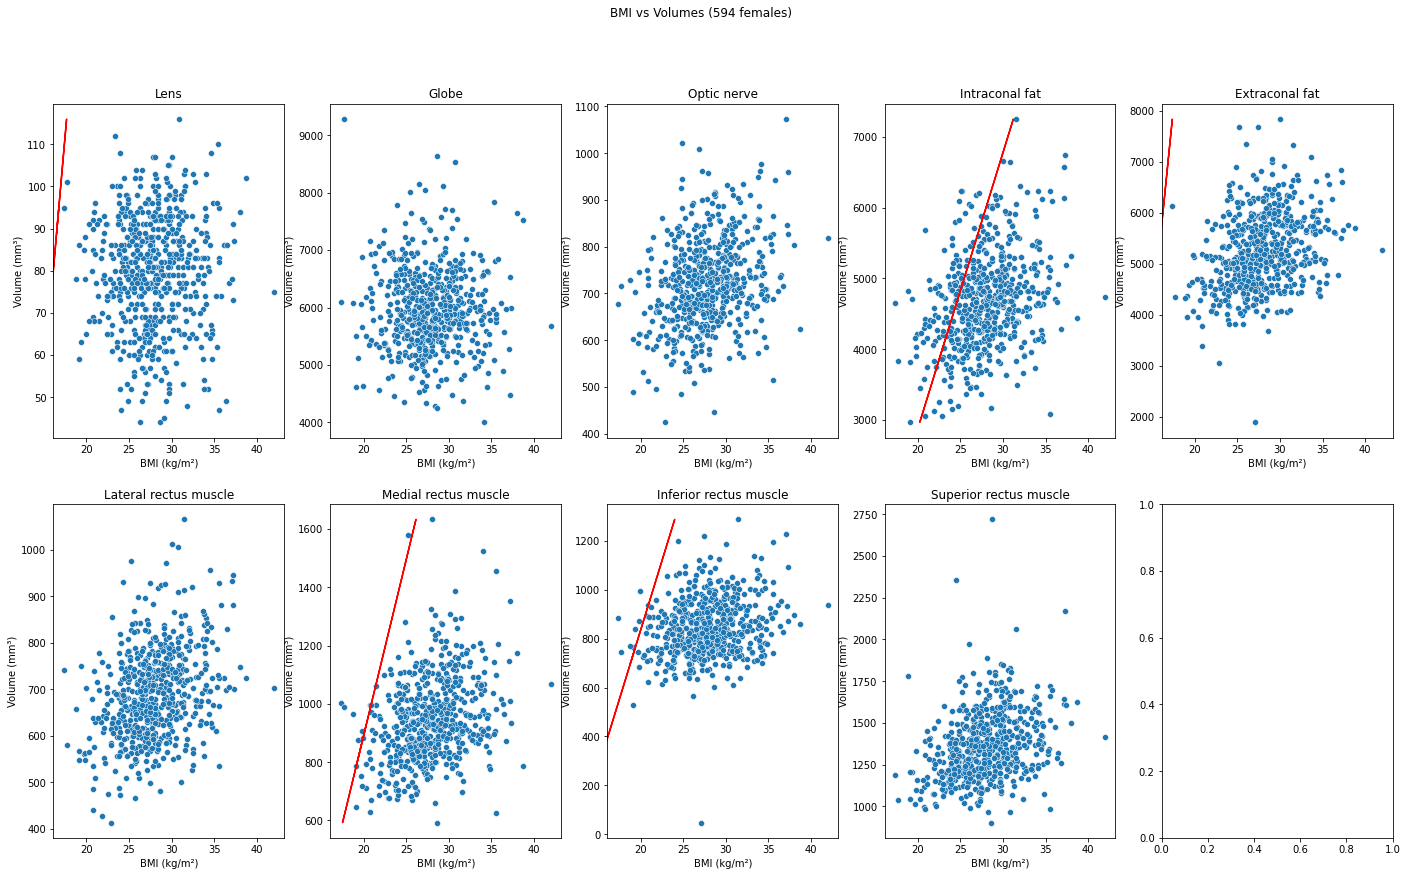

In [55]:
# Female group
female_group = sex_group.get_group("M").dropna() 

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label

# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig1, ax1 = plt.subplots(2, 5, figsize=(16*k, 9*k))
fig1.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fig1.patch.set_facecolor('white')
fix_axis = False
x_axis = [-2, 2]
y_axis = [19,31]

# Line per label (using intercept and slope)
def get_line_lens(x):
    return slope[0] * x + intercept
def get_line_globe(x):
    return slope[1] * x + intercept
def get_line_nerve(x):
    return slope[2] * x + intercept
def get_line_int_fat(x):
    return slope[3] * x + intercept
def get_line_ext_fat(x):
    return slope[4] * x + intercept
def get_line_lat_mus(x):
    return slope[5] * x + intercept
def get_line_med_mus(x):
    return slope[6] * x + intercept
def get_line_inf_mus(x):
    return slope[7] * x + intercept
def get_line_sup_mus(x):
    return slope[8] * x + intercept

# Lens
ax1[0][0].set_title(f'Lens')
plot1 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lens_female.flatten(), ax=ax1[0][0])
line_points = list(map(get_line_lens, volume_lens_female.flatten()))
line = Line2D(line_points, volume_lens_female.flatten(), color='red')
ax1[0][0].add_line(line)
ax1[0][0].set_xlabel('BMI (kg/m²)')
ax1[0][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][0].set_ylim(y_axis)

# Globe
ax1[0][1].set_title(f'Globe')
plot2 = sns.scatterplot(x=bmi_female.flatten(), y=volume_globe_female.flatten(), ax=ax1[0][1])
line_points = list(map(get_line_globe, volume_globe_female.flatten()))
line = Line2D(line_points, volume_globe_female.flatten(), color='red')
ax1[0][1].add_line(line)
ax1[0][1].set_xlabel('BMI (kg/m²)')
ax1[0][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][1].set_ylim(y_axis)

# Optic nerve
ax1[0][2].set_title(f'Optic nerve')
plot3 = sns.scatterplot(x=bmi_female.flatten(), y=volume_nerve_female.flatten(), ax=ax1[0][2])
line_points = list(map(get_line_nerve, volume_nerve_female.flatten()))
line = Line2D(line_points, volume_nerve_female.flatten(), color='red')
ax1[0][2].add_line(line)
ax1[0][2].set_xlabel('BMI (kg/m²)')
ax1[0][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][2].set_ylim(y_axis)

# Intraconal fat
ax1[0][3].set_title(f'Intraconal fat')
plot4 = sns.scatterplot(x=bmi_female.flatten(), y=volume_int_fat_female.flatten(), ax=ax1[0][3])
line_points = list(map(get_line_int_fat, volume_int_fat_female.flatten()))
line = Line2D(line_points, volume_int_fat_female.flatten(), color='red')
ax1[0][3].add_line(line)
ax1[0][3].set_xlabel('BMI (kg/m²)')
ax1[0][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][3].set_ylim(y_axis)

# Extraconal fat
ax1[0][4].set_title(f'Extraconal fat')
plot5 = sns.scatterplot(x=bmi_female.flatten(), y=volume_ext_fat_female.flatten(), ax=ax1[0][4])
line_points = list(map(get_line_ext_fat, volume_ext_fat_female.flatten()))
line = Line2D(line_points, volume_ext_fat_female.flatten(), color='red')
ax1[0][4].add_line(line)
ax1[0][4].set_xlabel('BMI (kg/m²)')
ax1[0][4].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[0][4].set_ylim(y_axis)

# Lateral rectus muscle
ax1[1][0].set_title(f'Lateral rectus muscle')
plot6 = sns.scatterplot(x=bmi_female.flatten(), y=volume_lat_mus_female.flatten(), ax=ax1[1][0])
line_points = list(map(get_line_lat_mus, volume_lat_mus_female.flatten()))
line = Line2D(line_points, volume_lat_mus_female.flatten(), color='red')
ax1[1][0].add_line(line)
ax1[1][0].set_xlabel('BMI (kg/m²)')
ax1[1][0].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][0].set_ylim(y_axis)

# Medial rectus muscle
ax1[1][1].set_title(f'Medial rectus muscle')
plot7 = sns.scatterplot(x=bmi_female.flatten(), y=volume_med_mus_female.flatten(), ax=ax1[1][1])
line_points = list(map(get_line_med_mus, volume_med_mus_female.flatten()))
line = Line2D(line_points, volume_med_mus_female.flatten(), color='red')
ax1[1][1].add_line(line)
ax1[1][1].set_xlabel('BMI (kg/m²)')
ax1[1][1].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][1].set_ylim(y_axis)

# Inferior rectus muscle
ax1[1][2].set_title(f'Inferior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_inf_mus_female.flatten(), ax=ax1[1][2])
line_points = list(map(get_line_inf_mus, volume_inf_mus_female.flatten()))
line = Line2D(line_points, volume_inf_mus_female.flatten(), color='red')
ax1[1][2].add_line(line)
ax1[1][2].set_xlabel('BMI (kg/m²)')
ax1[1][2].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][2].set_ylim(y_axis)

# Superior rectus muscle
ax1[1][3].set_title(f'Superior rectus muscle')
plot8 = sns.scatterplot(x=bmi_female.flatten(), y=volume_sup_mus_female.flatten(), ax=ax1[1][3])
line_points = list(map(get_line_sup_mus, volume_sup_mus_female.flatten()))
line = Line2D(line_points, volume_sup_mus_female.flatten(), color='red')
ax1[1][3].add_line(line)
ax1[1][3].set_xlabel('BMI (kg/m²)')
ax1[1][3].set_ylabel('Volume (mm³)')
if fix_axis:
    # ax[1].set_xlim(x_axis)
    ax1[1][3].set_ylim(y_axis)

plt.show()

# plt.savefig('/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume_males_norm.png')

Plot predictions

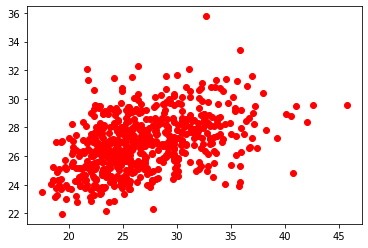

In [56]:
# Plot outputs
if train_test:
    plt.scatter(test[target], predictions,  color='red')
else:
    plt.scatter(train[target], predictions, color='red')

plt.show()

Linear regression per label

FEMALES 

Train shape: (615, 9)
Test shape: (0, 15) 

Lens
Shape before removing outliers = (615, 2)
Shape after removing outliers = (615, 2)
Slope = 0.007787285358784769 
Intercept = 26.337567313145428 
R value = 0.021768050308340593 
P value = 0.5900278354027464 
Stderr = 0.014445527335965722 

Globe
Shape before removing outliers = (615, 2)
Shape after removing outliers = (615, 2)
Slope = 5.1156470887669057e-05 
Intercept = 26.62686835064193 
R value = 0.007160676439554734 
P value = 0.85933558500063 
Stderr = 0.00028853941984800877 

Optic nerve
Shape before removing outliers = (615, 2)
Shape after removing outliers = (615, 2)
Slope = 0.015286630162898874 
Intercept = 17.545504830513956 
R value = 0.2686844792625878 
P value = 1.2478124829962718e-11 
Stderr = 0.0022134420193336665 

Intraconal fat
Shape before removing outliers = (615, 2)
Shape after removing outliers = (615, 2)
Slope = 0.0027549836097806677 
Intercept = 16.656484247698778 
R value = 0.30509470087172 
P value = 1.0

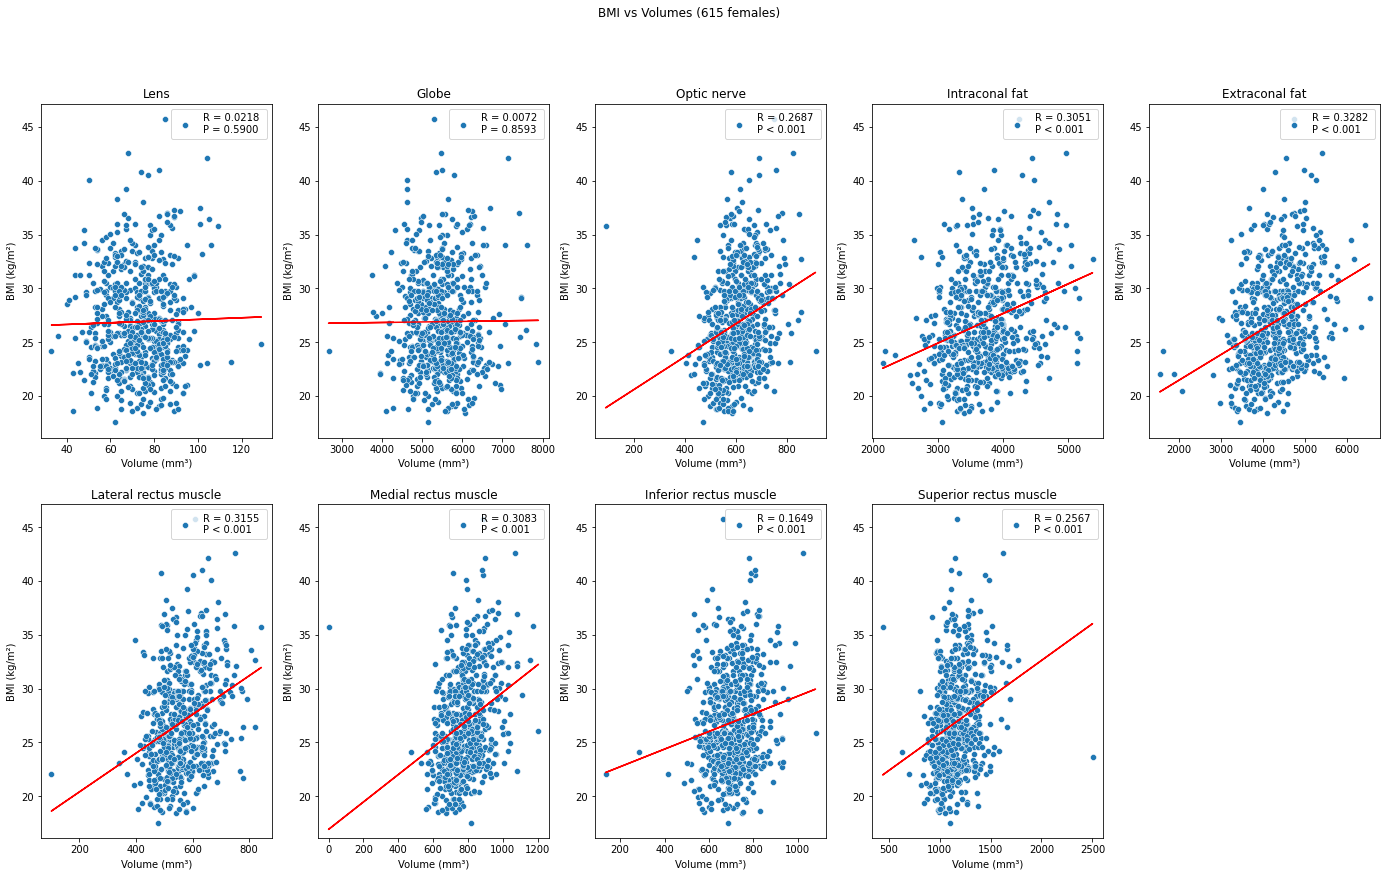

In [161]:
from sklearn.feature_selection import f_regression
# Import the linear models.
from sklearn import linear_model
import statsmodels.api as sma
# Import the scikit-learn function to compute error. Explained variance score.
from sklearn.metrics import mean_squared_error, r2_score

# Female group
female_group = sex_group.get_group("F").dropna() 
print('FEMALES \n')

# Get all the columns from the dataframe.
columns = female_group.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["index", "Subject", "Sex", "Weight", "Height", "BMI", "Age"]]
# print([columns[0]])

# Store the variable we'll be predicting on.
target = "BMI"

# Generate the training set.  Set random_state to be able to replicate results.
if train_test:
    train = female_group.sample(frac=0.8, random_state=1)
else: train = female_group

# Select anything not in the training set and put it in the testing set.
test = female_group.loc[~female_group.index.isin(train.index)]

# Print the shapes of both sets.
print(f'Train shape: {train[columns].shape}')
print(f'Test shape: {test.shape} \n')

ALPHA = 0.05 # for the p values
model = linear_model.LinearRegression() # linear model for the regression

# List labels
list_labels = ['Lens', 'Globe', 'Optic nerve', 'Intraconal fat', 'Extraconal fat', 'Lateral rectus muscle', 'Medial rectus muscle',
    'Inferior rectus muscle', 'Superior rectus muscle']

# Volumes
volume_lens_female = np.array([female_group["vol_lens"]])
volume_globe_female = np.array([female_group["vol_globe"]])
volume_nerve_female = np.array([female_group["vol_nerve"]])
volume_int_fat_female = np.array([female_group["vol_int_fat"]])
volume_ext_fat_female = np.array([female_group["vol_ext_fat"]])
volume_lat_mus_female = np.array([female_group["vol_lat_mus"]])
volume_med_mus_female = np.array([female_group["vol_med_mus"]])
volume_inf_mus_female = np.array([female_group["vol_inf_mus"]])
volume_sup_mus_female = np.array([female_group["vol_sup_mus"]])
volumes_female_list = np.array([volume_lens_female, volume_globe_female, volume_nerve_female, volume_int_fat_female, volume_ext_fat_female,
    volume_lat_mus_female, volume_med_mus_female, volume_inf_mus_female, volume_sup_mus_female])

# BMI
bmi_female = np.array([female_group["BMI"]])

# Plot: boxplot (2x5), x_axis=BMI, y_axis=volume per label
# Figure
k = 1.5 # Figure size to preserve ratio 16:9
fig = plt.figure(figsize=(16*k, 9*k))
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.suptitle(f'BMI vs Volumes ({female_group.shape[0]} females)')
fix_axis = False
# x_axis = [-2, 2]
y_axis = [0, 9000]

for n, c in enumerate(columns):

    print(list_labels[n])

    # print(train[c].shape)
    # print(train[target].shape)

    # 2D array having predictor and target
    arr = np.array([train[c], train[target]]).T
    print(f'Shape before removing outliers = {arr.shape}')

    # Remove outliers
    if remove_outliers == True:
        # Vol
        mean_vol = np.mean(arr[:,0])
        std_vol = np.std(arr[:,0])
        # Vol: mean - 2*std
        index_low_vol = list(np.array(np.where(arr[:,0] < (mean_vol - 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_vol, axis=0) # delete rows from array
        # Vol: mean + 2*std
        index_up_vol = list(np.array(np.where(arr[:,0] > (mean_vol + 2*std_vol))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_vol, axis=0) # delete rows from array
        # BMI
        mean_bmi = np.mean(arr[:,1])
        std_bmi = np.std(arr[:,1])
        # BMI: mean - 2*std
        index_low_bmi = list(np.array(np.where(arr[:,1] < (mean_bmi - 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_low_bmi, axis=0) # delete rows from array
        # BMI: mean + 2*std
        index_up_bmi = list(np.array(np.where(arr[:,1] > (mean_bmi + 2*std_bmi))).flatten()) # indeces of the values < Q1
        arr = np.delete(arr, index_up_bmi, axis=0) # delete rows from array

    print(f'Shape after removing outliers = {arr.shape}')

    # Linear regression
    result = stats.linregress(arr)
    slope = result.slope
    intercept = result.intercept
    r_value = result.rvalue
    p_value = result.pvalue
    stderr = result.stderr
    print(f'Slope = {slope} \nIntercept = {intercept} \nR value = {r_value} \nP value = {p_value} \nStderr = {stderr} \n')

    # Line per label (using intercept and slope)
    def get_line(x):
        return slope * x + intercept

    # Plot
    ax = plt.subplot(2, 5, n+1) # add a new subplot iteratively
    sns.scatterplot(y=bmi_female.flatten(), x=volumes_female_list[n].flatten(), ax=ax)
    line_points = list(map(get_line, volumes_female_list[n].flatten()))
    line = Line2D(volumes_female_list[n].flatten(), line_points, color='red')
    ax.add_line(line)
    # Title and axis labels
    ax.set_title(list_labels[n])
    ax.set_ylabel('BMI (kg/m²)')
    ax.set_xlabel('Volume (mm³)')
    # Legend
    p_value_plot = f'= {p_value:.4f}' if p_value >= 0.001 else '< 0.001'
    labels = [f'R = {r_value:.4f} \nP {p_value_plot}']
    ax.legend(labels=labels, loc='upper right')
    # Axis
    if fix_axis:
        # ax.set_xlim(x_axis)
        ax.set_ylim(y_axis)

filename = 'bmi_vs_volume_females_linear_regression_outliers_mean' if remove_outliers else 'bmi_vs_volume_females_linear_regression'
plt.savefig(f'/mnt/sda1/Repos/a-eye/Output/bmi_vs_volume/{filename}_inv.png')